In [1]:
import pandas as pd
import string
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import nltk
import subprocess
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

# plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from sklearn.metrics import precision_score, recall_score, f1_score
# metric (AUC, ROC, sensitivity & specificity)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
!pip install snntorch
import snntorch as snn
from snntorch import surrogate
from snntorch import utils
import snntorch.functional as SF
import math
!pip install ncps

import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch.utils.data as data
torch.manual_seed(2501)
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download("punkt")

# try:
#     nltk.data.find('wordnet.zip')
# except:
#     nltk.download('wordnet', download_dir='/kaggle/working/')
#     command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
#     subprocess.run(command.split())
#     nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet as wn



2024-04-11 16:29:28.624294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 16:29:28.624446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 16:29:28.762568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 3.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 3.4 MB/s eta 0:00:00


In [2]:
# dfTrain = pd.read_csv("/kaggle/input/info-retreval/preprocessed_trainv1.csv", encoding = 'ISO-8859-1').rename(columns={"Text":"Headline", "Sentiment":"Label"})
# dfTest = pd.read_csv("/kaggle/input/info-retreval/preprocessed_testv1.csv", encoding = 'ISO-8859-1').rename(columns={"FINAL Sentiment":"Label"})
# dfTest = dfTest[(dfTest['Label'] != "#VALUE!") & (~dfTest['Label'].isna())][["Label", "Headline"]].copy()


In [3]:
dfTest = pd.read_csv("/kaggle/input/info-retreval/test_pos_neg.csv", encoding = 'ISO-8859-1').rename(columns={"Sentiment":"Label"})
dfTrain = pd.read_csv("/kaggle/input/info-retreval/train_pos_neg.csv", encoding = 'ISO-8859-1').rename(columns={"Sentiment":"Label"})
dfTrain["Label"]=dfTrain["Label"].map({"POSITIVE":1, "NEGATIVE":0}).sample(frac=1).reset_index(drop=True)
dfTest["Label"]=dfTest["Label"].map({"POSITIVE":1, "NEGATIVE":0}).sample(frac=1).reset_index(drop=True)


In [4]:
ticker_to_name = {
    "aapl": "apple",
    "goog": "google",
    "googl": "google",
    "nvda": "nvidia",
    "msft": "microsoft",
    "tsla": "tesla"
}

In [5]:
def create_embedding_matrix(word_index, embedding_dict=None, d_model=100):
    """
     this function create the embedding matrix save in numpy array
    :param word_index: a dictionary with word: index_value
    :param embedding_dict: a dict with word embedding
    :d_model: the dimension of word pretrained embedding, here I just set to 100, we will define again
    :return a numpy array with embedding vectors for all known words
    """
    embedding_matrix = np.zeros((len(word_index) + 1, d_model))
    ## loop over all the words
    for word, index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index] = embedding_dict[word]
    return embedding_matrix

In [16]:

glove = pd.read_csv('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

MAX_LEN = 25
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(dfTrain.Headline.values.tolist())
X_train = tokenizer.texts_to_sequences(dfTrain.Headline.values)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_LEN)
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict=glove_embedding, d_model=100)

X_test = tokenizer.texts_to_sequences(dfTest.Headline.values)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float).to(device)


In [9]:
def prepare_target(target, seq_lengths, washout, batch_first=False):
    """ Preprocess target for offline training.

    Args:
        target (seq_len, batch, output_size): tensor containing
            the features of the target sequence.
        seq_lengths: list of lengths of each sequence in the batch.
        washout: number of initial timesteps during which output of the
            reservoir is not forwarded to the readout. One value per sample.
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``

    Returns:
        tensor containing the features of the batch's sequences rolled out along
        one axis, minus the washouts and the padded values.
    """

    if batch_first:
        target = target.transpose(0, 1)
    n_sequences = target.size(1)
    target_dim = target.size(2)
    train_len = sum(torch.tensor(seq_lengths) - torch.tensor(washout)).item()

    new_target = torch.zeros(train_len, target_dim, device=target.device)

    idx = 0
    for s in range(n_sequences):
        batch_len = seq_lengths[s] - washout[s]
        new_target[idx:idx + batch_len, :] = target[washout[s]:seq_lengths[s], s, :]
        idx += batch_len

    return new_target


def washout_tensor(tensor, washout, seq_lengths, bidirectional=False, batch_first=False):
    tensor = tensor.transpose(0, 1) if batch_first else tensor.clone()
    if type(seq_lengths) == list:
        seq_lengths = seq_lengths.copy()
    if type(seq_lengths) == torch.Tensor:
        seq_lengths = seq_lengths.clone()
        
    
    for b in range(tensor.size(1)):
        if washout[b] > 0:
            tmp = tensor[washout[b]:seq_lengths[b], b].clone()
            tensor[:seq_lengths[b] - washout[b], b] = tmp
            tensor[seq_lengths[b] - washout[b]:, b] = 0
            seq_lengths[b] -= washout[b]

            if bidirectional:
                tensor[seq_lengths[b] - washout[b]:, b] = 0
                seq_lengths[b] -= washout[b]

    if type(seq_lengths) == list:
        max_len = max(seq_lengths)
    else:
        max_len = max(seq_lengths).item()

    return tensor[:max_len], seq_lengths


import torch
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence, pad_packed_sequence



class ESN(nn.Module):
    """ Applies an Echo State Network to an input sequence. Multi-layer Echo
    State Network is based on paper
    Deep Echo State Network (DeepESN): A Brief Survey - Gallicchio, Micheli 2017

    Args:
        input_size: The number of expected features in the input x.
        hidden_size: The number of features in the hidden state h.
        output_size: The number of expected features in the output y.
        num_layers: Number of recurrent layers. Default: 1
        nonlinearity: The non-linearity to use ['tanh'|'relu'|'id'].
            Default: 'tanh'
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``
        leaking_rate: Leaking rate of reservoir's neurons. Default: 1
        spectral_radius: Desired spectral radius of recurrent weight matrix.
            Default: 0.9
        w_ih_scale: Scale factor for first layer's input weights (w_ih_l0). It
            can be a number or a tensor of size '1 + input_size' and first element
            is the bias' scale factor. Default: 1
        lambda_reg: Ridge regression's shrinkage parameter. Default: 1
        density: Recurrent weight matrix's density. Default: 1
        w_io: If 'True', then the network uses trainable input-to-output
            connections. Default: ``False``
        readout_training: Readout's traning algorithm ['gd'|'svd'|'cholesky'|'inv'].
            If 'gd', gradients are accumulated during backward
            pass. If 'svd', 'cholesky' or 'inv', the network will learn readout's
            parameters during the forward pass using ridge regression. The
            coefficients are computed using SVD, Cholesky decomposition or
            standard ridge regression formula. 'gd', 'cholesky' and 'inv'
            permit the usage of mini-batches to train the readout.
            If 'inv' and matrix is singular, pseudoinverse is used.
        output_steps: defines how the reservoir's output will be used by ridge
            regression method ['all', 'mean', 'last'].
            If 'all', the entire reservoir output matrix will be used.
            If 'mean', the mean of reservoir output matrix along the timesteps
            dimension will be used.
            If 'last', only the last timestep of the reservoir output matrix
            will be used.
            'mean' and 'last' are useful for classification tasks.

    Inputs: input, washout, h_0, target
        input (seq_len, batch, input_size): tensor containing the features of
            the input sequence. The input can also be a packed variable length
            sequence. See `torch.nn.utils.rnn.pack_padded_sequence`
        washout (batch): number of initial timesteps during which output of the
            reservoir is not forwarded to the readout. One value per batch's
            sample.
        h_0 (num_layers, batch, hidden_size): tensor containing
             the initial reservoir's hidden state for each element in the batch.
             Defaults to zero if not provided.

        target (seq_len*batch - washout*batch, output_size): tensor containing
            the features of the batch's target sequences rolled out along one
            axis, minus the washouts and the padded values. It is only needed
            for readout's training in offline mode. Use `prepare_target` to
            compute it.

    Outputs: output, h_n
        - output (seq_len, batch, hidden_size): tensor containing the output
        features (h_k) from the readout, for each k.
        - **h_n** (num_layers * num_directions, batch, hidden_size): tensor
          containing the reservoir's hidden state for k=seq_len.
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers=1,
                 nonlinearity='tanh', batch_first=False, leaking_rate=1,
                 spectral_radius=0.9, w_ih_scale=1, lambda_reg=0, density=1,
                 w_io=False, readout_training='svd', output_steps='all'):
        super(ESN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        if nonlinearity == 'tanh':
            mode = 'RES_TANH'
        elif nonlinearity == 'relu':
            mode = 'RES_RELU'
        elif nonlinearity == 'id':
            mode = 'RES_ID'
        else:
            raise ValueError("Unknown nonlinearity '{}'".format(nonlinearity))
        self.batch_first = batch_first
        self.leaking_rate = leaking_rate
        self.spectral_radius = spectral_radius
        if type(w_ih_scale) != torch.Tensor:
            self.w_ih_scale = torch.ones(input_size + 1)
            self.w_ih_scale *= w_ih_scale
        else:
            self.w_ih_scale = w_ih_scale

        self.lambda_reg = lambda_reg
        self.density = density
        self.w_io = w_io
        if readout_training in {'gd', 'svd', 'cholesky', 'inv'}:
            self.readout_training = readout_training
        else:
            raise ValueError("Unknown readout training algorithm '{}'".format(
                readout_training))

        self.reservoir = Reservoir(mode, input_size, hidden_size, num_layers,
                                   leaking_rate, spectral_radius,
                                   self.w_ih_scale, density,
                                   batch_first=batch_first)

        if w_io:
            self.readout = nn.Linear(input_size + hidden_size * num_layers,
                                     output_size)
        else:
            self.readout = nn.Linear(hidden_size * num_layers, output_size)
        if readout_training == 'offline':
            self.readout.weight.requires_grad = False

        if output_steps in {'all', 'mean', 'last'}:
            self.output_steps = output_steps
        else:
            raise ValueError("Unknown task '{}'".format(
                output_steps))

        self.XTX = None
        self.XTy = None
        self.X = None

    def forward(self, input, washout, h_0=None, target=None):
        with torch.no_grad():
            is_packed = isinstance(input, PackedSequence)

            output, hidden = self.reservoir(input, h_0)
            if is_packed:
                output, seq_lengths = pad_packed_sequence(output,
                                                          batch_first=self.batch_first)
            else:
                if self.batch_first:
                    seq_lengths = output.size(0) * [output.size(1)]
                else:
                    seq_lengths = output.size(1) * [output.size(0)]

            if self.batch_first:
                output = output.transpose(0, 1)
                

            output, seq_lengths = washout_tensor(output, washout, seq_lengths)

            if self.w_io:
                if is_packed:
                    input, input_lengths = pad_packed_sequence(input,
                                                          batch_first=self.batch_first)
                else:
                    input_lengths = [input.size(0)] * input.size(1)

                if self.batch_first:
                    input = input.transpose(0, 1)

                input, _ = washout_tensor(input, washout, input_lengths)

                output = torch.cat([input, output], -1)

            if self.readout_training == 'gd' or target is None:
                with torch.enable_grad():
                    output = self.readout(output)

                    if is_packed:
                        for i in range(output.size(1)):
                            if seq_lengths[i] < output.size(0):
                                output[seq_lengths[i]:, i] = 0

                    if self.batch_first:
                        output = output.transpose(0, 1)

                    # Uncomment if you want packed output.
                    # if is_packed:
                    #     output = pack_padded_sequence(output, seq_lengths,
                    #                                   batch_first=self.batch_first)

                    return output, hidden

            else:
                batch_size = output.size(1)

                X = torch.ones(target.size(0), 1 + output.size(2), device=target.device)
                row = 0
                for s in range(batch_size):
                    if self.output_steps == 'all':
                        X[row:row + seq_lengths[s], 1:] = output[:seq_lengths[s],
                                                          s]
                        row += seq_lengths[s]
                    elif self.output_steps == 'mean':
                        X[row, 1:] = torch.mean(output[:seq_lengths[s], s], 0)
                        row += 1
                    elif self.output_steps == 'last':
                        X[row, 1:] = output[seq_lengths[s] - 1, s]
                        row += 1

                if self.readout_training == 'cholesky':
                    if self.XTX is None:
                        self.XTX = torch.mm(X.t(), X)
                        self.XTy = torch.mm(X.t(), target)
                    else:
                        self.XTX += torch.mm(X.t(), X)
                        self.XTy += torch.mm(X.t(), target)

                elif self.readout_training == 'svd':
                    # Scikit-Learn SVD solver for ridge regression.
                    U, s, V = torch.svd(X)
                    idx = s > 1e-15  # same default value as scipy.linalg.pinv
                    s_nnz = s[idx][:, None]
                    UTy = torch.mm(U.t(), target)
                    d = torch.zeros(s.size(0), 1, device=X.device)
                    d[idx] = s_nnz / (s_nnz ** 2 + self.lambda_reg)
                    d_UT_y = d * UTy
                    W = torch.mm(V, d_UT_y).t()

                    self.readout.bias = nn.Parameter(W[:, 0])
                    self.readout.weight = nn.Parameter(W[:, 1:])
                elif self.readout_training == 'inv':
                    self.X = X
                    if self.XTX is None:
                        self.XTX = torch.mm(X.t(), X)
                        self.XTy = torch.mm(X.t(), target)
                    else:
                        self.XTX += torch.mm(X.t(), X)
                        self.XTy += torch.mm(X.t(), target)

                return None, None

    def fit(self):
        if self.readout_training in {'gd', 'svd'}:
            return

        if self.readout_training == 'cholesky':
            W = torch.linalg.solve(self.XTy,
                                   self.XTX + self.lambda_reg * torch.eye(
                                       self.XTX.size(0), device=self.XTX.device))[0].t()
            self.XTX = None
            self.XTy = None

            self.readout.bias = nn.Parameter(W[:, 0])
            self.readout.weight = nn.Parameter(W[:, 1:])
        elif self.readout_training == 'inv':
            I = (self.lambda_reg * torch.eye(self.XTX.size(0))).to(
                self.XTX.device)
            A = self.XTX + I
            X_rank = torch.linalg.matrix_rank(A).item()

            if X_rank == self.X.size(0):
                W = torch.mm(torch.inverse(A), self.XTy).t()
            else:
                W = torch.mm(torch.pinverse(A), self.XTy).t()

            self.readout.bias = nn.Parameter(W[:, 0])
            self.readout.weight = nn.Parameter(W[:, 1:])

            self.XTX = None
            self.XTy = None

    def reset_parameters(self):
        self.reservoir.reset_parameters()
        self.readout.reset_parameters()

        
        
from torch.nn import functional as F
from torch.nn.utils.rnn import PackedSequence
import torch.sparse
import re


def apply_permutation(tensor, permutation, dim=1):
    # type: (Tensor, Tensor, int) -> Tensor
    return tensor.index_select(dim, permutation)


class Reservoir(nn.Module):

    def __init__(self, mode, input_size, hidden_size, num_layers, leaking_rate,
                 spectral_radius, w_ih_scale,
                 density, bias=True, batch_first=False):
        super(Reservoir, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.leaking_rate = leaking_rate
        self.spectral_radius = spectral_radius
        self.w_ih_scale = w_ih_scale
        self.density = density
        self.bias = bias
        self.batch_first = batch_first

        self._all_weights = []
        for layer in range(num_layers):
            layer_input_size = input_size if layer == 0 else hidden_size

            w_ih = nn.Parameter(torch.Tensor(hidden_size, layer_input_size))
            w_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
            b_ih = nn.Parameter(torch.Tensor(hidden_size))
            layer_params = (w_ih, w_hh, b_ih)

            param_names = ['weight_ih_l{}{}', 'weight_hh_l{}{}']
            if bias:
                param_names += ['bias_ih_l{}{}']
            param_names = [x.format(layer, '') for x in param_names]

            for name, param in zip(param_names, layer_params):
                setattr(self, name, param)
            self._all_weights.append(param_names)

        self.reset_parameters()

    def _apply(self, fn):
        ret = super(Reservoir, self)._apply(fn)
        return ret

    def reset_parameters(self):
        weight_dict = self.state_dict()
        for key, value in weight_dict.items():
            if key == 'weight_ih_l0':
                nn.init.uniform_(value, -1, 1)
                value *= self.w_ih_scale[1:]
            elif re.fullmatch('weight_ih_l[^0]*', key):
                nn.init.uniform_(value, -1, 1)
            elif re.fullmatch('bias_ih_l[0-9]*', key):
                nn.init.uniform_(value, -1, 1)
                value *= self.w_ih_scale[0]
            elif re.fullmatch('weight_hh_l[0-9]*', key):
                w_hh = torch.Tensor(self.hidden_size * self.hidden_size)
                w_hh.uniform_(-1, 1)
                if self.density < 1:
                    zero_weights = torch.randperm(
                        int(self.hidden_size * self.hidden_size))
                    zero_weights = zero_weights[
                                   :int(
                                       self.hidden_size * self.hidden_size * (
                                                   1 - self.density))]
                    w_hh[zero_weights] = 0
                w_hh = w_hh.view(self.hidden_size, self.hidden_size)
                abs_eigs = torch.abs(torch.linalg.eigvals(w_hh))
                weight_dict[key] = w_hh * (self.spectral_radius / torch.max(abs_eigs))

        self.load_state_dict(weight_dict)

    def check_input(self, input, batch_sizes):
        # type: (Tensor, Optional[Tensor]) -> None
        expected_input_dim = 2 if batch_sizes is not None else 3
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                'input must have {} dimensions, got {}'.format(
                    expected_input_dim, input.dim()))
        if self.input_size != input.size(-1):
            raise RuntimeError(
                'input.size(-1) must be equal to input_size. Expected {}, got {}'.format(
                    self.input_size, input.size(-1)))

    def get_expected_hidden_size(self, input, batch_sizes):
        # type: (Tensor, Optional[Tensor]) -> Tuple[int, int, int]
        if batch_sizes is not None:
            mini_batch = batch_sizes[0]
            mini_batch = int(mini_batch)
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        expected_hidden_size = (self.num_layers, mini_batch, self.hidden_size)
        return expected_hidden_size

    def check_hidden_size(self, hx, expected_hidden_size, msg='Expected hidden size {}, got {}'):
        # type: (Tensor, Tuple[int, int, int], str) -> None
        if hx.size() != expected_hidden_size:
            raise RuntimeError(msg.format(expected_hidden_size, tuple(hx.size())))

    def check_forward_args(self, input, hidden, batch_sizes):
        # type: (Tensor, Tensor, Optional[Tensor]) -> None
        self.check_input(input, batch_sizes)
        expected_hidden_size = self.get_expected_hidden_size(input, batch_sizes)

        self.check_hidden_size(hidden, expected_hidden_size)

    def permute_hidden(self, hx, permutation):
        # type: (Tensor, Optional[Tensor]) -> Tensor
        if permutation is None:
            return hx
        return apply_permutation(hx, permutation)

    def forward(self, input, hx=None):
        is_packed = isinstance(input, PackedSequence)
        if is_packed:
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = int(batch_sizes[0])
        else:
            batch_sizes = None
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None

        if hx is None:
            hx = input.new_zeros(self.num_layers, max_batch_size,
                                 self.hidden_size, requires_grad=False)
        else:
            # Each batch of the hidden state should match the input sequence that
            # the user believes he/she is passing in.
            hx = self.permute_hidden(hx, sorted_indices)

        flat_weight = None

        self.check_forward_args(input, hx, batch_sizes)
        func = AutogradReservoir(
            self.mode,
            self.input_size,
            self.hidden_size,
            num_layers=self.num_layers,
            batch_first=self.batch_first,
            train=self.training,
            variable_length=is_packed,
            flat_weight=flat_weight,
            leaking_rate=self.leaking_rate
        )
        output, hidden = func(input, self.all_weights, hx, batch_sizes)
        if is_packed:
            output = PackedSequence(output, batch_sizes, sorted_indices, unsorted_indices)
        return output, self.permute_hidden(hidden, unsorted_indices)

    def extra_repr(self):
        s = '({input_size}, {hidden_size}'
        if self.num_layers != 1:
            s += ', num_layers={num_layers}'
        if self.bias is not True:
            s += ', bias={bias}'
        if self.batch_first is not False:
            s += ', batch_first={batch_first}'
        s += ')'
        return s.format(**self.__dict__)

    def __setstate__(self, d):
        super(Reservoir, self).__setstate__(d)
        self.__dict__.setdefault('_data_ptrs', [])
        if 'all_weights' in d:
            self._all_weights = d['all_weights']
        if isinstance(self._all_weights[0][0], str):
            return
        num_layers = self.num_layers
        self._all_weights = []
        for layer in range(num_layers):
            weights = ['weight_ih_l{}{}', 'weight_hh_l{}{}', 'bias_ih_l{}{}']
            weights = [x.format(layer) for x in weights]
            if self.bias:
                self._all_weights += [weights]
            else:
                self._all_weights += [weights[:2]]

    @property
    def all_weights(self):
        return [[getattr(self, weight) for weight in weights] for weights in
                self._all_weights]


def StackedRNN(inners, num_layers, lstm=False, train=True):
    num_directions = len(inners)
    total_layers = num_layers * num_directions

    def forward(input, hidden, weight, batch_sizes):
        assert (len(weight) == total_layers)
        next_hidden = []
        all_layers_output = []

        for i in range(num_layers):
            all_output = []
            for j, inner in enumerate(inners):
                l = i * num_directions + j

                hy, output = inner(input, hidden[l], weight[l], batch_sizes)
                next_hidden.append(hy)
                all_output.append(output)

            input = torch.cat(all_output, input.dim() - 1)
            all_layers_output.append(input)

        all_layers_output = torch.cat(all_layers_output, -1)
        next_hidden = torch.cat(next_hidden, 0).view(
            total_layers, *next_hidden[0].size())

        return next_hidden, all_layers_output

    return forward

def AutogradReservoir(mode, input_size, hidden_size, num_layers=1,
                      batch_first=False, train=True,
                      batch_sizes=None, variable_length=False, flat_weight=None,
                      leaking_rate=1):
    if mode == 'RES_TANH':
        cell = ResTanhCell
    elif mode == 'RES_RELU':
        cell = ResReLUCell
    elif mode == 'RES_ID':
        cell = ResIdCell

    if variable_length:
        layer = (VariableRecurrent(cell, leaking_rate),)
    else:
        layer = (Recurrent(cell, leaking_rate),)

    func = StackedRNN(layer,
                      num_layers,
                      False,
                      train=train)

    def forward(input, weight, hidden, batch_sizes):
        if batch_first and batch_sizes is None:
            input = input.transpose(0, 1)

        nexth, output = func(input, hidden, weight, batch_sizes)

        if batch_first and not variable_length:
            output = output.transpose(0, 1)

        return output, nexth

    return forward


def Recurrent(inner, leaking_rate):
    def forward(input, hidden, weight, batch_sizes):
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = inner(input[i], hidden, leaking_rate, *weight)
            # hack to handle LSTM
            output.append(hidden[0] if isinstance(hidden, tuple) else hidden)

        output = torch.cat(output, 0).view(input.size(0), *output[0].size())

        return hidden, output

    return forward


def VariableRecurrent(inner, leaking_rate):
    def forward(input, hidden, weight, batch_sizes):
        output = []
        input_offset = 0
        last_batch_size = batch_sizes[0]
        hiddens = []
        flat_hidden = not isinstance(hidden, tuple)
        if flat_hidden:
            hidden = (hidden,)
        for batch_size in batch_sizes:
            step_input = input[input_offset:input_offset + batch_size]
            input_offset += batch_size

            dec = last_batch_size - batch_size
            if dec > 0:
                hiddens.append(tuple(h[-dec:] for h in hidden))
                hidden = tuple(h[:-dec] for h in hidden)
            last_batch_size = batch_size

            if flat_hidden:
                hidden = (inner(step_input, hidden[0], leaking_rate, *weight),)
            else:
                hidden = inner(step_input, hidden, leaking_rate, *weight)

            output.append(hidden[0])
        hiddens.append(hidden)
        hiddens.reverse()

        hidden = tuple(torch.cat(h, 0) for h in zip(*hiddens))
        assert hidden[0].size(0) == batch_sizes[0]
        if flat_hidden:
            hidden = hidden[0]
        output = torch.cat(output, 0)

        return hidden, output

    return forward


    num_directions = len(inners)
    total_layers = num_layers * num_directions

    def forward(input, hidden, weight, batch_sizes):
        assert (len(weight) == total_layers)
        next_hidden = []
        all_layers_output = []

        for i in range(num_layers):
            all_output = []
            for j, inner in enumerate(inners):
                l = i * num_directions + j

                hy, output = inner(input, hidden[l], weight[l], batch_sizes)
                next_hidden.append(hy)
                all_output.append(output)

            input = torch.cat(all_output, input.dim() - 1)
            all_layers_output.append(input)

        all_layers_output = torch.cat(all_layers_output, -1)
        next_hidden = torch.cat(next_hidden, 0).view(
            total_layers, *next_hidden[0].size())

        return next_hidden, all_layers_output

    return forward


def ResTanhCell(input, hidden, leaking_rate, w_ih, w_hh, b_ih=None):
    hy_ = torch.tanh(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh))
    hy = (1 - leaking_rate) * hidden + leaking_rate * hy_
    return hy


def ResReLUCell(input, hidden, leaking_rate, w_ih, w_hh, b_ih=None):
    hy_ = F.relu(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh))
    hy = (1 - leaking_rate) * hidden + leaking_rate * hy_
    return hy


def ResIdCell(input, hidden, leaking_rate, w_ih, w_hh, b_ih=None):
    hy_ = F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh)
    hy = (1 - leaking_rate) * hidden + leaking_rate * hy_
    return hy

In [10]:
class TextESNClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, washout, nonlinearity='tanh', leaking_rate=1.0, spectral_radius=0.9, w_ih_scale=1.0, lambda_reg=1.0, density=1.0):
        super(TextESNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True).to(device)
        self.esn = ESN(input_size=embedding_matrix.size(1), hidden_size=hidden_size, num_layers=num_layers, w_io=True, output_size=hidden_size, output_steps='mean', batch_first=False, nonlinearity=nonlinearity, leaking_rate=leaking_rate, spectral_radius=spectral_radius, w_ih_scale=w_ih_scale, lambda_reg=lambda_reg, density=density)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.washout = washout  # Set the washout as a fixed attribute, or make it adjustable as per requirement

    def forward(self, x, h_0=None):
        # Transpose x from [batch_size, seq_len, input_size] to [seq_len, batch_size, input_size]

        # Proceed with embedding if applicable
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Now x is of shape [seq_len, batch_size, input_size]

        # Pass through ESN
        x, _ = self.esn(x, washout=torch.full((x.size(1),), self.washout, dtype=torch.long, device=x.device))  # ESN should be defined with batch_first=False

        # You might need to adjust how you handle outputs depending on your specific model and task
        x = x[-1, :, :]  # Now x is of shape [batch_size, hidden_size]

        # Pass through the output layer
        logits = self.output_layer(x)
        return logits

In [13]:
def train_test_NN_metrics(model, criterion, optimizer, num_epochs, train_loader, test_loader, device, verbose):
    metrics = {
        'Epoch': [],
        'Train Loss': [],
        'Train Accuracy': [],
        'Train Precision': [],
        'Train Recall': [],
        'Train F1 Score': [],
        'Test Loss': [],
        'Test Accuracy': [],
        'Test Precision': [],
        'Test Recall': [],
        'Test F1 Score': [],
        'Epoch Time': []
    }

    for epoch in range(num_epochs):  # num_epochs is the number of epochs you want to train for
        epoch_start_time = time.time()  # Start time of the epoch

        # Training phase
        model.train()
        running_loss = 0
        running_correct = 0
        total_train = 0
        all_train_predicted = []
        all_train_labels = []

        for inputs, labels in train_loader:  # train_loader is your DataLoader for training data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Get model predictions
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model parameters

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)
            all_train_predicted.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        train_loss = running_loss / total_train
        train_accuracy = running_correct / total_train
        train_precision = precision_score(all_train_labels, all_train_predicted, average='macro')
        train_recall = recall_score(all_train_labels, all_train_predicted, average='macro')
        train_f1 = f1_score(all_train_labels, all_train_predicted, average='macro')
        
        # Testing phase
        model.eval()
        running_loss = 0
        running_correct = 0
        total_test = 0
        all_test_predicted = []
        all_test_labels = []

        with torch.no_grad():  # No need to calculate gradients during testing
            for inputs, labels in test_loader:  # test_loader is your DataLoader for testing data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                running_correct += (predicted == labels).sum().item()
                total_test += labels.size(0)
                all_test_predicted.extend(predicted.cpu().numpy())
                all_test_labels.extend(labels.cpu().numpy())

        test_loss = running_loss / total_test
        test_accuracy = running_correct / total_test
        test_precision = precision_score(all_test_labels, all_test_predicted, average='macro')
        test_recall = recall_score(all_test_labels, all_test_predicted, average='macro')
        test_f1 = f1_score(all_test_labels, all_test_predicted, average='macro')
        

        # Append metrics for this epoch to the dictionary
        metrics['Epoch'].append(epoch + 1)
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_accuracy)
        metrics['Train Precision'].append(train_precision)
        metrics['Train Recall'].append(train_recall)
        metrics['Train F1 Score'].append(train_f1)
        metrics['Test Loss'].append(test_loss)
        metrics['Test Accuracy'].append(test_accuracy)
        metrics['Test Precision'].append(test_precision)
        metrics['Test Recall'].append(test_recall)
        metrics['Test F1 Score'].append(test_f1)
        metrics['Epoch Time'].append(epoch_duration)
        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, "
                  f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%, Test Precision: {test_precision:.4f}, "
                  f"Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}, Epoch Time: {epoch_duration:.2f} sec")

    df_metrics = pd.DataFrame(metrics)
    return df_metrics

In [139]:
def plot_metrics(df_metrics):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # Creating a grid of subplots
    fig.suptitle('Training and Testing Metrics Over Epochs')

    # Plotting Train and Test Loss
    axs[0, 0].plot(df_metrics['Epoch'], df_metrics['Train Loss'], label='Train Loss')
    axs[0, 0].plot(df_metrics['Epoch'], df_metrics['Test Loss'], label='Test Loss', linestyle='--')
    axs[0, 0].set_title('Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plotting Train and Test Accuracy
    axs[0, 1].plot(df_metrics['Epoch'], df_metrics['Train Accuracy'], label='Train Accuracy')
    axs[0, 1].plot(df_metrics['Epoch'], df_metrics['Test Accuracy'], label='Test Accuracy', linestyle='--')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    # Plotting Train and Test Precision
    axs[1, 0].plot(df_metrics['Epoch'], df_metrics['Train Precision'], label='Train Precision')
    axs[1, 0].plot(df_metrics['Epoch'], df_metrics['Test Precision'], label='Test Precision', linestyle='--')
    axs[1, 0].set_title('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].legend()

    # Plotting Train and Test Recall
    axs[1, 1].plot(df_metrics['Epoch'], df_metrics['Train Recall'], label='Train Recall')
    axs[1, 1].plot(df_metrics['Epoch'], df_metrics['Test Recall'], label='Test Recall', linestyle='--')
    axs[1, 1].set_title('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].legend()

    # Plotting Train and Test F1 Score
    axs[2, 0].plot(df_metrics['Epoch'], df_metrics['Train F1 Score'], label='Train F1 Score')
    axs[2, 0].plot(df_metrics['Epoch'], df_metrics['Test F1 Score'], label='Test F1 Score', linestyle='--')
    axs[2, 0].set_title('F1 Score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].set_ylabel('F1 Score')
    axs[2, 0].legend()

    # Plotting Epoch Time
    axs[2, 1].plot(df_metrics['Epoch'], df_metrics['Epoch Time'], label='Epoch Time')
    axs[2, 1].set_title('Time per Epoch')
    axs[2, 1].set_xlabel('Epoch')
    axs[2, 1].set_ylabel('Time (sec)')
    axs[2, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
    plt.show()

Epoch 1/30, Train Loss: 3.4934, Train Accuracy: 50.39%, Train Precision: 0.5206, Train Recall: 0.5173, Train F1 Score: 0.4895, Test Loss: 1.6226, Test Accuracy: 49.53%, Test Precision: 0.5143, Test Recall: 0.5084, Test F1 Score: 0.4448, Epoch Time: 0.67 sec
Epoch 2/30, Train Loss: 2.4009, Train Accuracy: 46.29%, Train Precision: 0.4621, Train Recall: 0.4619, Train F1 Score: 0.4618, Test Loss: 1.0031, Test Accuracy: 46.72%, Test Precision: 0.4736, Test Recall: 0.4831, Test F1 Score: 0.4241, Epoch Time: 0.65 sec
Epoch 3/30, Train Loss: 1.0189, Train Accuracy: 55.86%, Train Precision: 0.5546, Train Recall: 0.5441, Train F1 Score: 0.5282, Test Loss: 1.1267, Test Accuracy: 52.97%, Test Precision: 0.5308, Test Recall: 0.5308, Test F1 Score: 0.5297, Epoch Time: 0.65 sec
Epoch 4/30, Train Loss: 1.1948, Train Accuracy: 51.95%, Train Precision: 0.5162, Train Recall: 0.5161, Train F1 Score: 0.5160, Test Loss: 1.5241, Test Accuracy: 47.66%, Test Precision: 0.4705, Test Recall: 0.4718, Test F1 Scor

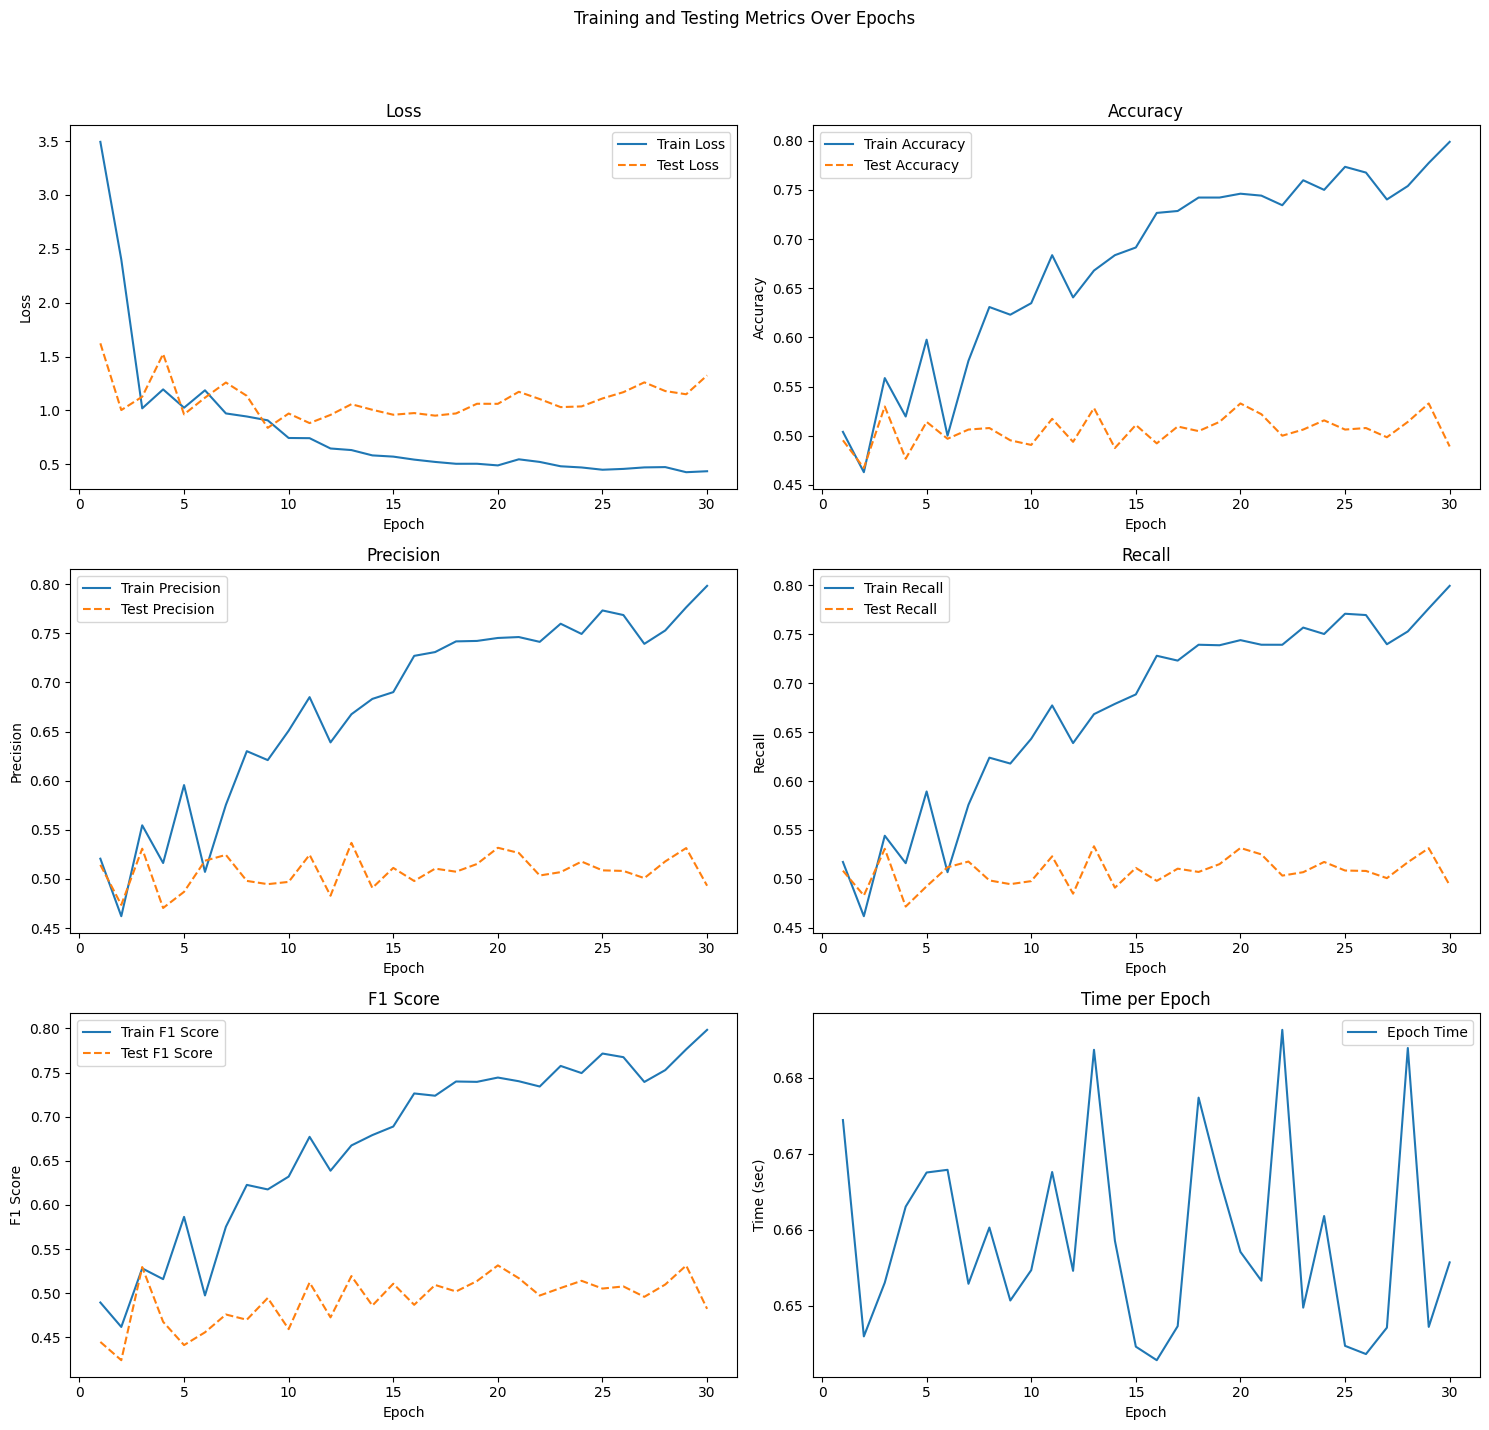

In [19]:
model = TextESNClassifier(embedding_matrix_tensor, hidden_size=128,num_layers=2, num_classes=2, washout=2).to(device)

batch_size=128
num_epochs=30

# X_train_tensor = torch.tensor(X_train, dtype=torch.long)
# X_train_labels_tensor = torch.tensor(dfTrain["Label"].values, dtype=torch.long)
# train_dataset = TensorDataset(X_train_tensor, X_train_labels_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

X_train_tensor = torch.tensor(X_test[:512], dtype=torch.long)
X_train_labels_tensor = torch.tensor(dfTest["Label"].values[:512], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, X_train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
X_test_tensor = torch.tensor(X_test[512:], dtype=torch.long)
X_test_labels_tensor = torch.tensor(dfTest["Label"].values[512:], dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, X_test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# X_test_tensor = torch.tensor(X_test, dtype=torch.long)
# X_test_labels_tensor = torch.tensor(dfTest["Label"].values, dtype=torch.long)
# test_dataset = TensorDataset(X_test_tensor, X_test_labels_tensor)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-2)

df_metrics = train_test_NN_metrics(model, criterion, optimizer, num_epochs, train_loader, test_loader, device, verbose=True)
plot_metrics(df_metrics)

In [21]:
class ESNClassifier2(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, washout):
        super(ESNClassifier2, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True).to(device)
        # First ESN layer
        self.esn1 = ESN(input_size=embedding_matrix.size(1), hidden_size=hidden_size, num_layers=num_layers, w_io=True, output_size=hidden_size, output_steps='all', batch_first=False)
        # LSTM layer positioned between the two ESN layers
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,  bidirectional=True, batch_first=False)
        # Second ESN layer, follows the LSTM layer
        self.esn2 = ESN(input_size=2*hidden_size, hidden_size=hidden_size, num_layers=num_layers, w_io=True, output_size=hidden_size, output_steps='mean', batch_first=False)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.washout = washout  # Set the washout as a fixed attribute, or make it adjustable as per requirement

    def forward(self, x):
        # Transpose x from [batch_size, seq_len, input_size] to [seq_len, batch_size, input_size]
        x = self.embedding(x)
        x = x.transpose(0, 1)  # Now x is of shape [seq_len, batch_size, input_size]

        # Pass through the first ESN
        x, _ = self.esn1(x, washout=torch.full((x.size(1),), self.washout, dtype=torch.long, device=x.device))

        # Pass through LSTM and capture its last hidden state
        x, (h_n, _) = self.lstm(x)  # h_n will be used to initialize the second ESN
        # Pass through the second ESN, using h_n from the LSTM as h_0
        # Ensure h_n is properly reshaped or processed to match the expected initial state format for esn2
        x, _ = self.esn2(x, washout=torch.full((x.size(1),), self.washout, dtype=torch.long, device=x.device))

        # Taking the last output of all sequences for the final classification
        x = x[-1, :, :]  # Now x is of shape [batch_size, hidden_size]

        # Pass through the output layer
        logits = self.output_layer(x)
        return logits


Epoch 1/30, Train Loss: 0.7168, Train Accuracy: 49.80%, Train Precision: 0.4927, Train Recall: 0.4928, Train F1 Score: 0.4917, Test Loss: 0.7024, Test Accuracy: 50.78%, Test Precision: 0.4884, Test Recall: 0.4930, Test F1 Score: 0.4439, Epoch Time: 1.32 sec
Epoch 2/30, Train Loss: 0.6771, Train Accuracy: 56.84%, Train Precision: 0.5660, Train Recall: 0.5658, Train F1 Score: 0.5658, Test Loss: 0.7423, Test Accuracy: 48.59%, Test Precision: 0.5023, Test Recall: 0.5003, Test F1 Score: 0.3588, Epoch Time: 1.26 sec
Epoch 3/30, Train Loss: 0.6654, Train Accuracy: 58.98%, Train Precision: 0.6260, Train Recall: 0.5674, Train F1 Score: 0.5227, Test Loss: 0.7055, Test Accuracy: 49.69%, Test Precision: 0.4907, Test Recall: 0.4912, Test F1 Score: 0.4863, Epoch Time: 1.28 sec
Epoch 4/30, Train Loss: 0.6522, Train Accuracy: 63.28%, Train Precision: 0.6310, Train Recall: 0.6307, Train F1 Score: 0.6308, Test Loss: 0.7155, Test Accuracy: 52.50%, Test Precision: 0.5252, Test Recall: 0.5252, Test F1 Scor

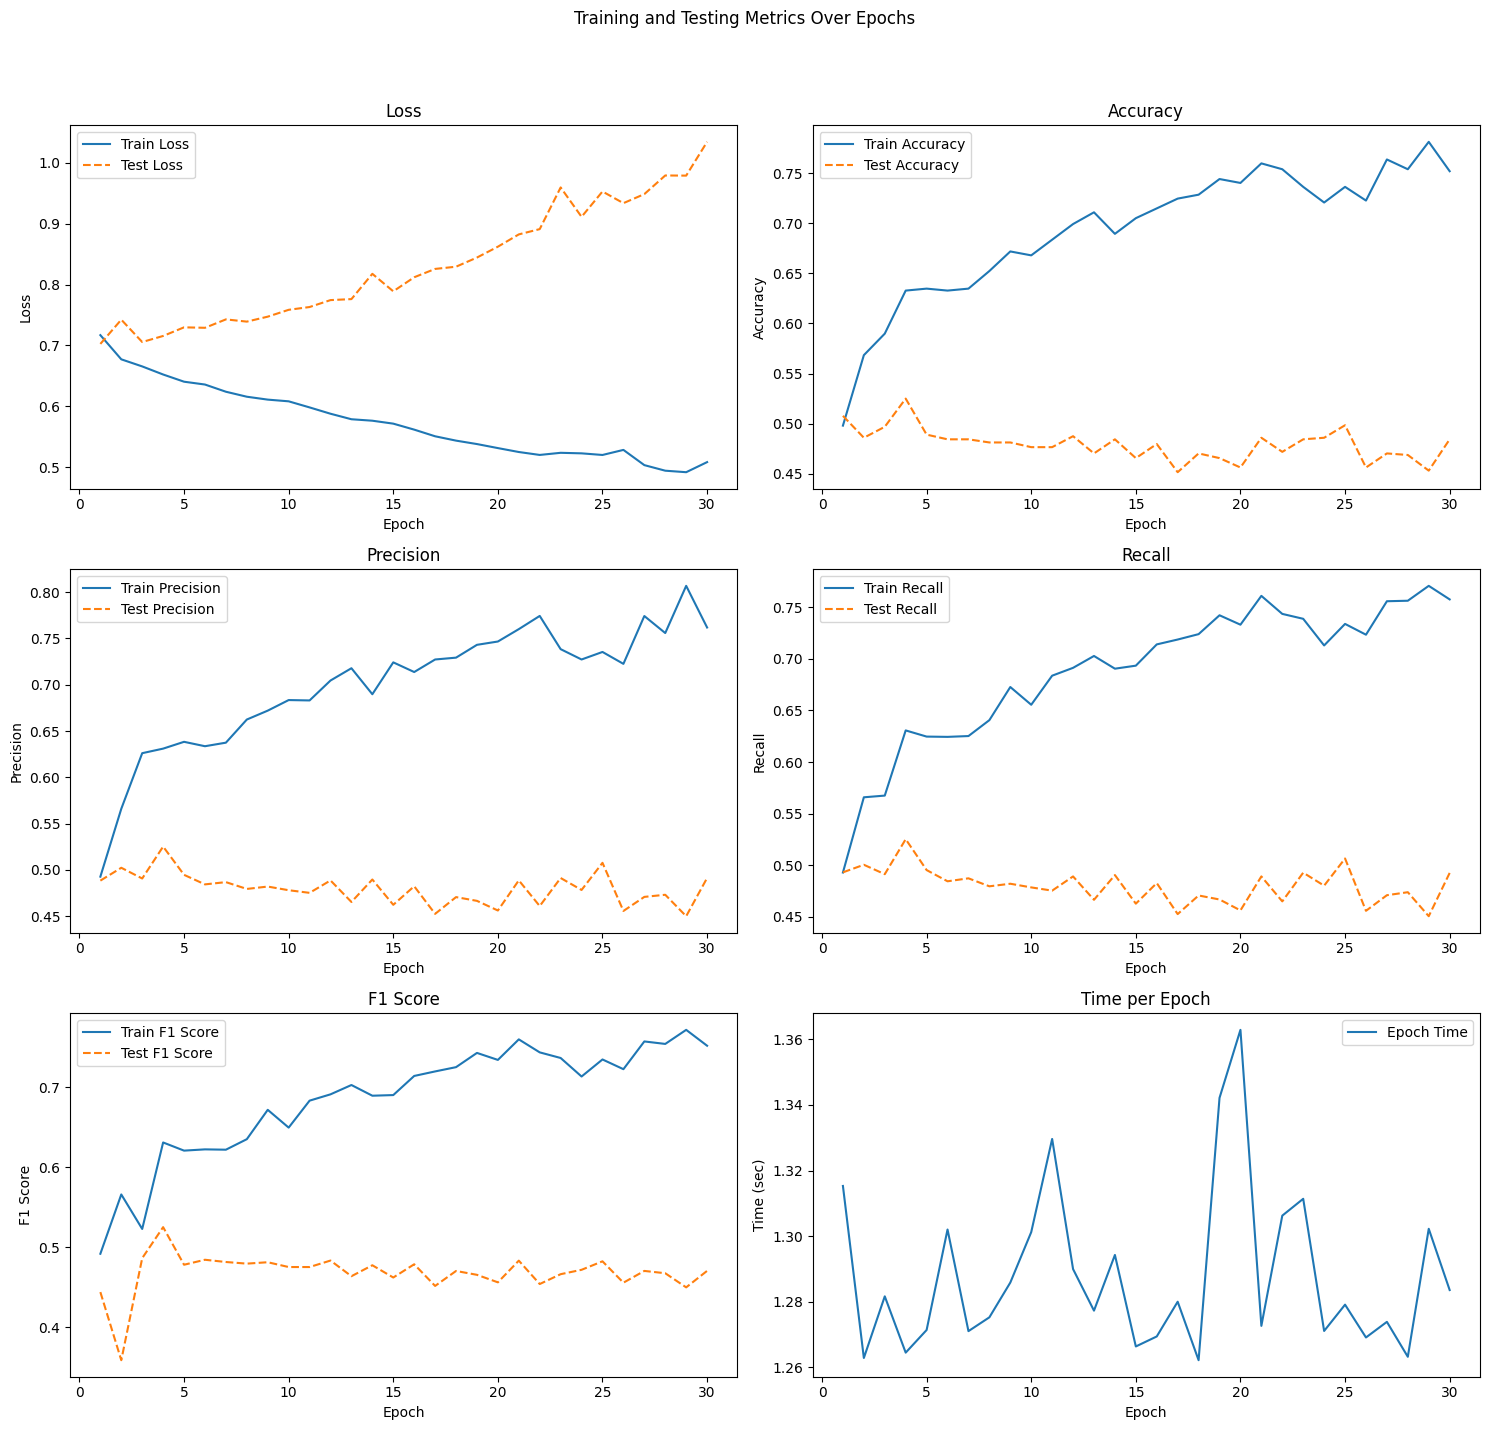

In [22]:
model = ESNClassifier2(embedding_matrix_tensor, hidden_size=128,num_layers=2, num_classes=2, washout=2).to(device)


batch_size=128
num_epochs=30

# X_train_tensor = torch.tensor(X_train, dtype=torch.long)
# X_train_labels_tensor = torch.tensor(dfTrain["Label"].values, dtype=torch.long)
# train_dataset = TensorDataset(X_train_tensor, X_train_labels_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

X_train_tensor = torch.tensor(X_test[:512], dtype=torch.long)
X_train_labels_tensor = torch.tensor(dfTest["Label"].values[:512], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, X_train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
X_test_tensor = torch.tensor(X_test[512:], dtype=torch.long)
X_test_labels_tensor = torch.tensor(dfTest["Label"].values[512:], dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, X_test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# X_test_tensor = torch.tensor(X_test, dtype=torch.long)
# X_test_labels_tensor = torch.tensor(dfTest["Label"].values, dtype=torch.long)
# test_dataset = TensorDataset(X_test_tensor, X_test_labels_tensor)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
df_metrics = train_test_NN_metrics(model, criterion, optimizer, num_epochs, train_loader, test_loader, device, verbose=True)
plot_metrics(df_metrics)

In [24]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.query_layer = nn.Linear(hidden_size, hidden_size)
        self.key_layer = nn.Linear(hidden_size, hidden_size)
        self.value_layer = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        # x is expected to be of shape [seq_len, batch_size, hidden_size]
        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)

        # Compute attention scores
        scores = torch.bmm(query.transpose(0, 1), key.transpose(0, 1).transpose(1, 2)) / (query.size(2) ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)

        # Apply attention weights to values
        attended = torch.bmm(attn_weights, value.transpose(0, 1))

        return attended.transpose(0, 1)  # Return to shape [seq_len, batch_size, hidden_size]

class ESNClassifier3(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_classes, washout):
        super(ESNClassifier3, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True).to(device)
        self.esn1 = ESN(input_size=embedding_matrix.size(1), hidden_size=hidden_size, num_layers=num_layers, w_io=True, output_size=hidden_size, output_steps='mean', batch_first=False)
        self.attention1 = AttentionLayer(hidden_size)
        self.esn2 = ESN(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, w_io=True, output_size=hidden_size, output_steps='mean', batch_first=False)

        # Additional Attention and ESN layers
        self.attention2 = AttentionLayer(hidden_size)
        self.esn3 = ESN(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, w_io=True, output_size=hidden_size, output_steps='mean', batch_first=False)

        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.washout = washout

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)  # [seq_len, batch_size, input_size]

        # First ESN and Attention layer
        esn1_output, _ = self.esn1(x, washout=torch.full((x.size(1),), self.washout, dtype=torch.long, device=x.device))
        attention1_output = self.attention1(esn1_output)
        combined1_output = esn1_output + attention1_output  # Element-wise addition (skip connection)

        # First ESN's output passed to second ESN
        esn2_output, _ = self.esn2(combined1_output, washout=torch.full((x.size(1),), self.washout, dtype=torch.long, device=x.device))

        # Additional Attention and ESN layers
        attention2_output = self.attention2(esn2_output)
        combined2_output = esn2_output + attention2_output  # Element-wise addition (skip connection)
        esn3_output, _ = self.esn3(combined2_output, washout=torch.full((x.size(1),), self.washout, dtype=torch.long, device=x.device))

        # Taking the last output of all sequences for the final classification
        final_output = esn3_output[-1, :, :]

        logits = self.output_layer(final_output)
        return logits


In [ ]:
model = ESNClassifier3(embedding_matrix_tensor, hidden_size=128, num_layers=2, num_classes=2, washout=2).to(device)


batch_size=128
num_epochs=30

# X_train_tensor = torch.tensor(X_train, dtype=torch.long)
# X_train_labels_tensor = torch.tensor(dfTrain["Label"].values, dtype=torch.long)
# train_dataset = TensorDataset(X_train_tensor, X_train_labels_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# X_test_tensor = torch.tensor(X_test, dtype=torch.long)
# X_test_labels_tensor = torch.tensor(dfTest["Label"].values, dtype=torch.long)
# test_dataset = TensorDataset(X_test_tensor, X_test_labels_tensor)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

X_train_tensor = torch.tensor(X_test[:512], dtype=torch.long)
X_train_labels_tensor = torch.tensor(dfTest["Label"].values[:512], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, X_train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
X_test_tensor = torch.tensor(X_test[512:], dtype=torch.long)
X_test_labels_tensor = torch.tensor(dfTest["Label"].values[512:], dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, X_test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)

df_metrics = train_test_NN_metrics(model, criterion, optimizer, num_epochs, train_loader, test_loader, device, verbose=True)
plot_metrics(df_metrics)

Epoch 1/30, Train Loss: 0.7905, Train Accuracy: 47.85%, Train Precision: 0.4749, Train Recall: 0.4750, Train F1 Score: 0.4748, Test Loss: 0.8260, Test Accuracy: 50.62%, Test Precision: 0.5352, Test Recall: 0.5218, Test F1 Score: 0.4628, Epoch Time: 1.97 sec
Epoch 2/30, Train Loss: 0.6749, Train Accuracy: 58.98%, Train Precision: 0.5872, Train Recall: 0.5813, Train F1 Score: 0.5779, Test Loss: 0.7846, Test Accuracy: 45.31%, Test Precision: 0.4492, Test Recall: 0.4502, Test F1 Score: 0.4483, Epoch Time: 1.89 sec
Epoch 3/30, Train Loss: 0.6264, Train Accuracy: 66.21%, Train Precision: 0.6605, Train Recall: 0.6584, Train F1 Score: 0.6587, Test Loss: 0.8252, Test Accuracy: 48.59%, Test Precision: 0.4994, Test Recall: 0.4995, Test F1 Score: 0.4573, Epoch Time: 1.93 sec
Epoch 4/30, Train Loss: 0.6067, Train Accuracy: 67.58%, Train Precision: 0.6794, Train Recall: 0.6678, Train F1 Score: 0.6668, Test Loss: 0.7778, Test Accuracy: 47.50%, Test Precision: 0.4749, Test Recall: 0.4748, Test F1 Scor

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [19]:
batch_size = 128

X_train_tensor = torch.tensor(X_test[:512], dtype=torch.long)
X_train_labels_tensor = torch.tensor(dfTest["Label"].values[:512], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, X_train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
X_test_tensor = torch.tensor(X_test[512:], dtype=torch.long)
X_test_labels_tensor = torch.tensor(dfTest["Label"].values[512:], dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, X_test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)
embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float).to(device)


In [233]:
class SimpleSNN(nn.Module):
    def __init__(self, embedding_matrix, slope=25, beta=0.9):
        super().__init__()
        spike_grad = snn.surrogate.fast_sigmoid(slope=slope) #

        # Initialize embedding layer
        self.embedding = nn.Embedding(embedding_matrix.size(0), embedding_matrix.size(1))
        self.embedding.weight = nn.Parameter(embedding_matrix)

        # Initialize layers (2 linear layers and 2 leaky layers)
        self.fc1 = nn.Linear(embedding_matrix.size(1), 128)  # Adjust input dimension
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(64, 64)  # Adjust input dimension
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc3 = nn.Linear(800, 2) 
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        embedded = self.embedding(x)
        cur1 = F.max_pool1d(self.fc1(embedded), 2)
        spk1, mem1 = self.lif1(cur1, mem1)
        cur2 = F.max_pool1d(self.fc2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)
        cur3 = self.fc3(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)
        return spk3, mem3


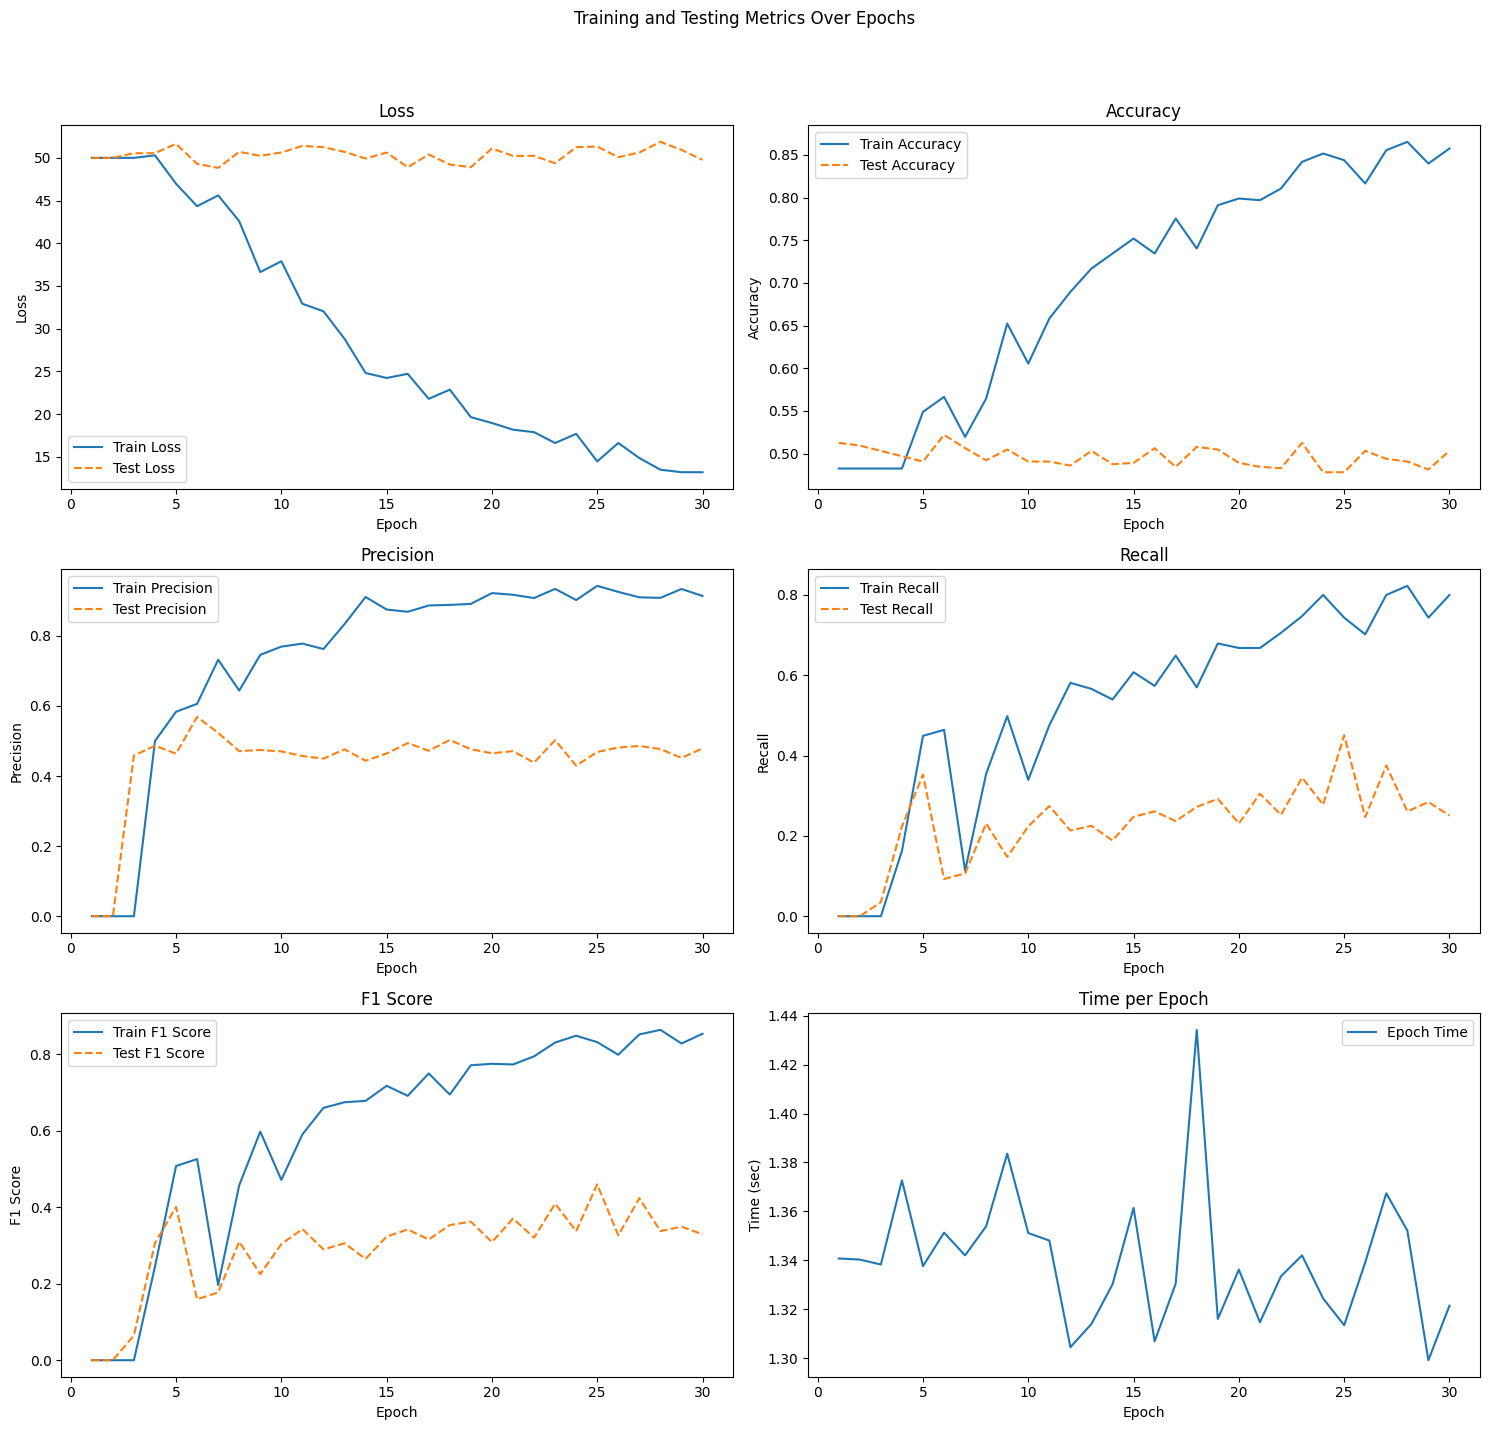

In [234]:
model = SimpleSNN(embedding_matrix_tensor).to(device)
criterion = SF.mse_count_loss(correct_rate=1.0, incorrect_rate=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999))
num_epochs = 30
num_steps = 100
df_metrics = train_test_SNN_metrics(model, criterion, optimizer, train_loader, test_loader, device, num_epochs, num_steps, population_code=False, num_classes=False, verbose=False)
plot_metrics(df_metrics)

In [85]:
def forward_pass(model, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(model)  # resets hidden states for all LIF neurons in net

    for step in range(num_steps):
        spk_out, mem_out = model(data)
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)
    return torch.stack(spk_rec), torch.stack(mem_rec)


def batch_accuracy(train_loader, net, num_steps, device):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()

        train_loader = iter(train_loader)
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec, _ = forward_pass(net, num_steps, data)

            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

    return acc/total

In [162]:
def confusion_matrix_rate(spk_out, targets, population_code=False, num_classes=False):
    """Compute confusion matrix using spike count.

    :param spk_out: Output spikes of shape [num_steps x batch_size x num_outputs]
    :type spk_out: torch.Tensor

    :param targets: Target tensor (without one-hot-encoding) of shape [batch_size]
    :type targets: torch.Tensor

    :return: confusion_matrix
    :rtype: numpy.ndarray
    """
    if population_code:
        _, _, num_outputs = snn.functional.acc._prediction_check(spk_out)
        _, idx = snn.functional.acc._population_code(spk_out, num_classes, num_outputs).max(1)
    else:
        _, idx = spk_out.sum(dim=0).max(1)

    # Convert targets and idx to CPU numpy arrays for sklearn compatibility
    targets_np = targets.detach().cpu().numpy()
    idx_np = idx.detach().cpu().numpy()
    # Calculate confusion matrix
    cm = confusion_matrix(targets_np, idx_np)
    return cm

In [132]:
def train_test_SNN_metrics(model, criterion, optimizer, train_loader, test_loader, device, num_epochs,num_steps, population_code=False, num_classes=False, verbose=False):
    metrics = {
        'Epoch': [],
        'Train Loss': [],
        'Train Accuracy': [],
        'Train Precision': [],
        'Train Recall': [],
        'Train F1 Score': [],
        'Test Loss': [],
        'Test Accuracy': [],
        'Test Precision': [],
        'Test Recall': [],
        'Test F1 Score': [],
        'Epoch Time': []
    }

    for epoch in range(num_epochs):  # num_epochs is the number of epochs you want to train for
        epoch_start_time = time.time()  # Start time of the epoch
          
        # Training phase
        model.train()
        running_loss = 0
        total_train = 0
        tn = fp = fn = tp = 0
        for inputs, labels in iter(train_loader): # train_loader is your DataLoader for training data
            inputs, labels = inputs.to(device), labels.to(device)
#             labels = torch.reshape(labels, [batch_size, 1])
            optimizer.zero_grad()  # Zero the gradients
            outputs, _ = forward_pass(model, num_steps, inputs)
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model parameters
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            cm = confusion_matrix_rate(outputs, labels, population_code=population_code, num_classes=num_classes)
            tn_batch, fp_batch, fn_batch, tp_batch = cm.ravel()
            tn += tn_batch
            fp += fp_batch
            fn += fn_batch
            tp += tp_batch
            
        # Calculate and store epoch time
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        train_loss = running_loss / total_train
        train_accuracy = (tp + tn) / (tp + tn + fp + fn)
        train_precision =  tp / (tp + fp) if (tp + fp)> 0 else 0
        train_recall =  tp / (tp + fn) if (tp + fn)> 0 else 0
        train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall) if (train_precision + train_recall)> 0 else 0

        # Testing phase
        model.eval()
        with torch.no_grad():  # No need to calculate gradients during testing
            tn = fp = fn = tp = 0
            total_test = 0
            running_loss = 0
            for inputs, labels in test_loader:  # test_loader is your DataLoader for testing data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = forward_pass(model, num_steps, inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                total_test += labels.size(0)
                cm = confusion_matrix_rate(outputs, labels, population_code=population_code, num_classes=num_classes)
                tn_batch, fp_batch, fn_batch, tp_batch = cm.ravel()
                tn += tn_batch
                fp += fp_batch
                fn += fn_batch
                tp += tp_batch

        test_loss = running_loss / total_test
        test_accuracy = (tp + tn) / (tp + tn + fp + fn)
        test_precision = tp / (tp + fp) if (tp + fp)> 0 else 0
        test_recall = tp / (tp + fn) if (tp + fn)> 0 else 0
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall)> 0 else 0

        # Append metrics for this epoch to the dictionary
        metrics['Epoch'].append(epoch + 1)
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_accuracy)
        metrics['Train Precision'].append(train_precision)
        metrics['Train Recall'].append(train_recall)
        metrics['Train F1 Score'].append(train_f1)
        metrics['Test Loss'].append(test_loss)
        metrics['Test Accuracy'].append(test_accuracy)
        metrics['Test Precision'].append(test_precision)
        metrics['Test Recall'].append(test_recall)
        metrics['Test F1 Score'].append(test_f1)
        metrics['Epoch Time'].append(epoch_duration)
        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, "
                  f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%, Test Precision: {test_precision:.4f}, "
                  f"Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}, Epoch Time: {epoch_duration:.2f} sec")

    df_metrics = pd.DataFrame(metrics)
    return df_metrics

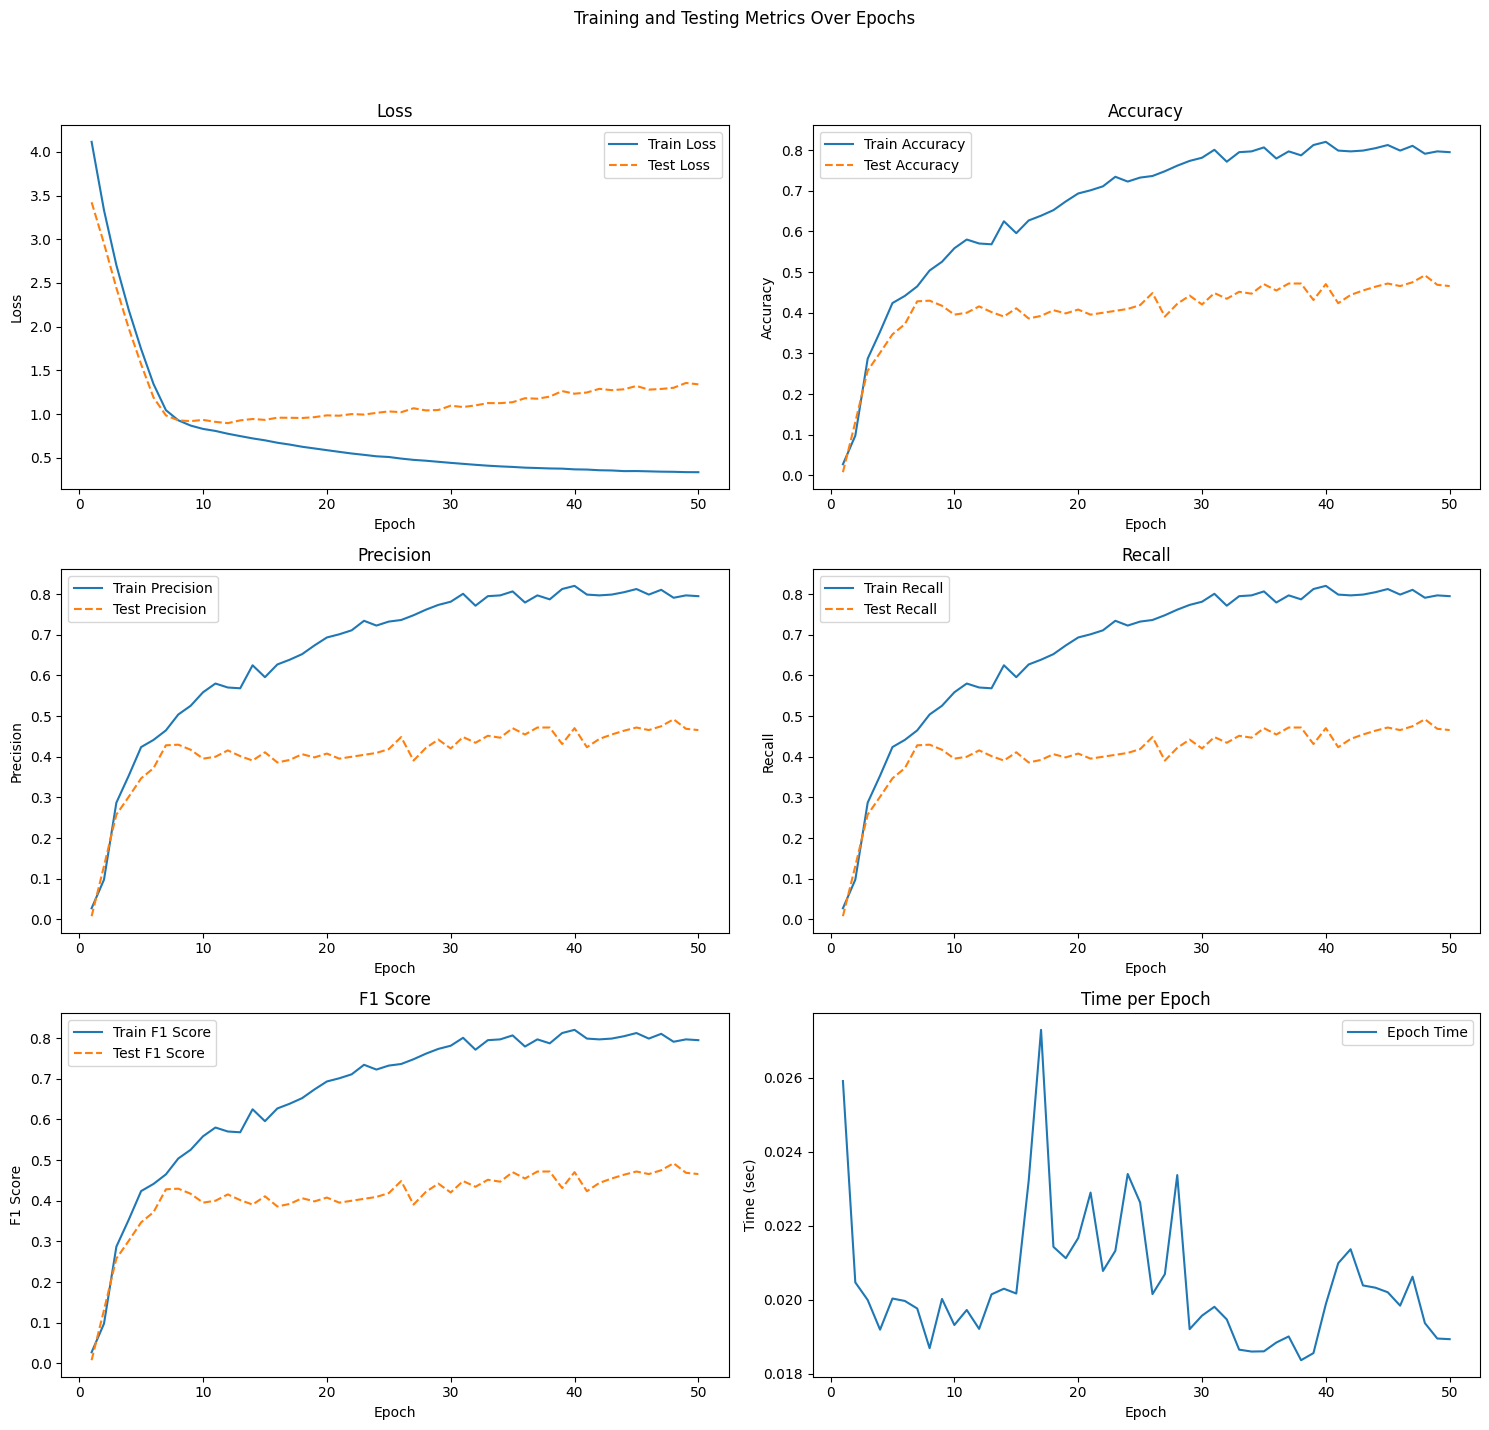

In [212]:
class CNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_layer1, hidden_layer2):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.conv1 = nn.Conv1d(embedding_matrix.size(1), hidden_layer1, 3)
        self.conv2 = nn.Conv1d(hidden_layer1, hidden_layer2, 5)
        self.fc1 = nn.Linear(hidden_layer2 * 4, 2)  # Assuming the size after convolutions and poolings is `hidden_layer2 * 4`

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2).contiguous()

        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)

        # Assuming `x` is reshaped or flattened as needed before being passed to the fully connected layer
        x = x.view(x.size(0), -1)  # Reshaping, `x.size(0)` is typically the batch size
        return x
    
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Initialize the metrics dictionary
    metrics = {
        'Epoch': [],
        'Train Loss': [],
        'Train Accuracy': [],
        'Train Precision': [],
        'Train Recall': [],
        'Train F1 Score': [],
        'Test Loss': [],
        'Test Accuracy': [],
        'Test Precision': [],
        'Test Recall': [],
        'Test F1 Score': [],
        'Epoch Time': []
    }
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        # Training phase
        model.train()
        total_loss = 0
        true_labels = []
        pred_labels = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predictions.cpu().numpy())
        
        train_loss = total_loss / len(train_loader.dataset)
        train_accuracy = accuracy_score(true_labels, pred_labels)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='micro')
        epoch_end = time.time()
        # Evaluation phase
        model.eval()
        total_loss = 0
        true_labels = []
        pred_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                
                _, predictions = torch.max(outputs, 1)
                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(predictions.cpu().numpy())
        
        test_loss = total_loss / len(test_loader.dataset)
        test_accuracy = accuracy_score(true_labels, pred_labels)
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='micro')        
        
        
        # Record the metrics for this epoch
        metrics['Epoch'].append(epoch + 1)
        metrics['Train Loss'].append(train_loss)
        metrics['Train Accuracy'].append(train_accuracy)
        metrics['Train Precision'].append(train_precision)
        metrics['Train Recall'].append(train_recall)
        metrics['Train F1 Score'].append(train_f1)
        metrics['Test Loss'].append(test_loss)
        metrics['Test Accuracy'].append(test_accuracy)
        metrics['Test Precision'].append(test_precision)
        metrics['Test Recall'].append(test_recall)
        metrics['Test F1 Score'].append(test_f1)
        metrics['Epoch Time'].append(epoch_end - epoch_start)
        
    return pd.DataFrame(metrics)

# Example usage:
model =CNN(embedding_matrix_tensor, 64, 32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
df_metrics = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=50)
plot_metrics(df_metrics)

In [313]:
class SNNCNN(nn.Module):
    def __init__(self,embedding_matrix, hidden_layer1, hidden_layer2, beta = 0.9):
        super().__init__()
        spike_grad = surrogate.fast_sigmoid() # fast sigmoid surrogate gradient
        self.embeding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.conv1 = nn.Conv1d(embedding_matrix_tensor.size(1), hidden_layer1, 3)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv1d(hidden_layer1, hidden_layer2, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(96, 2)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        x = self.embeding(x)
        print(x.shape)
        x = x.transpose(1, 2).contiguous()
        cur1 = F.max_pool1d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool1d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)

        return spk3, mem3
    

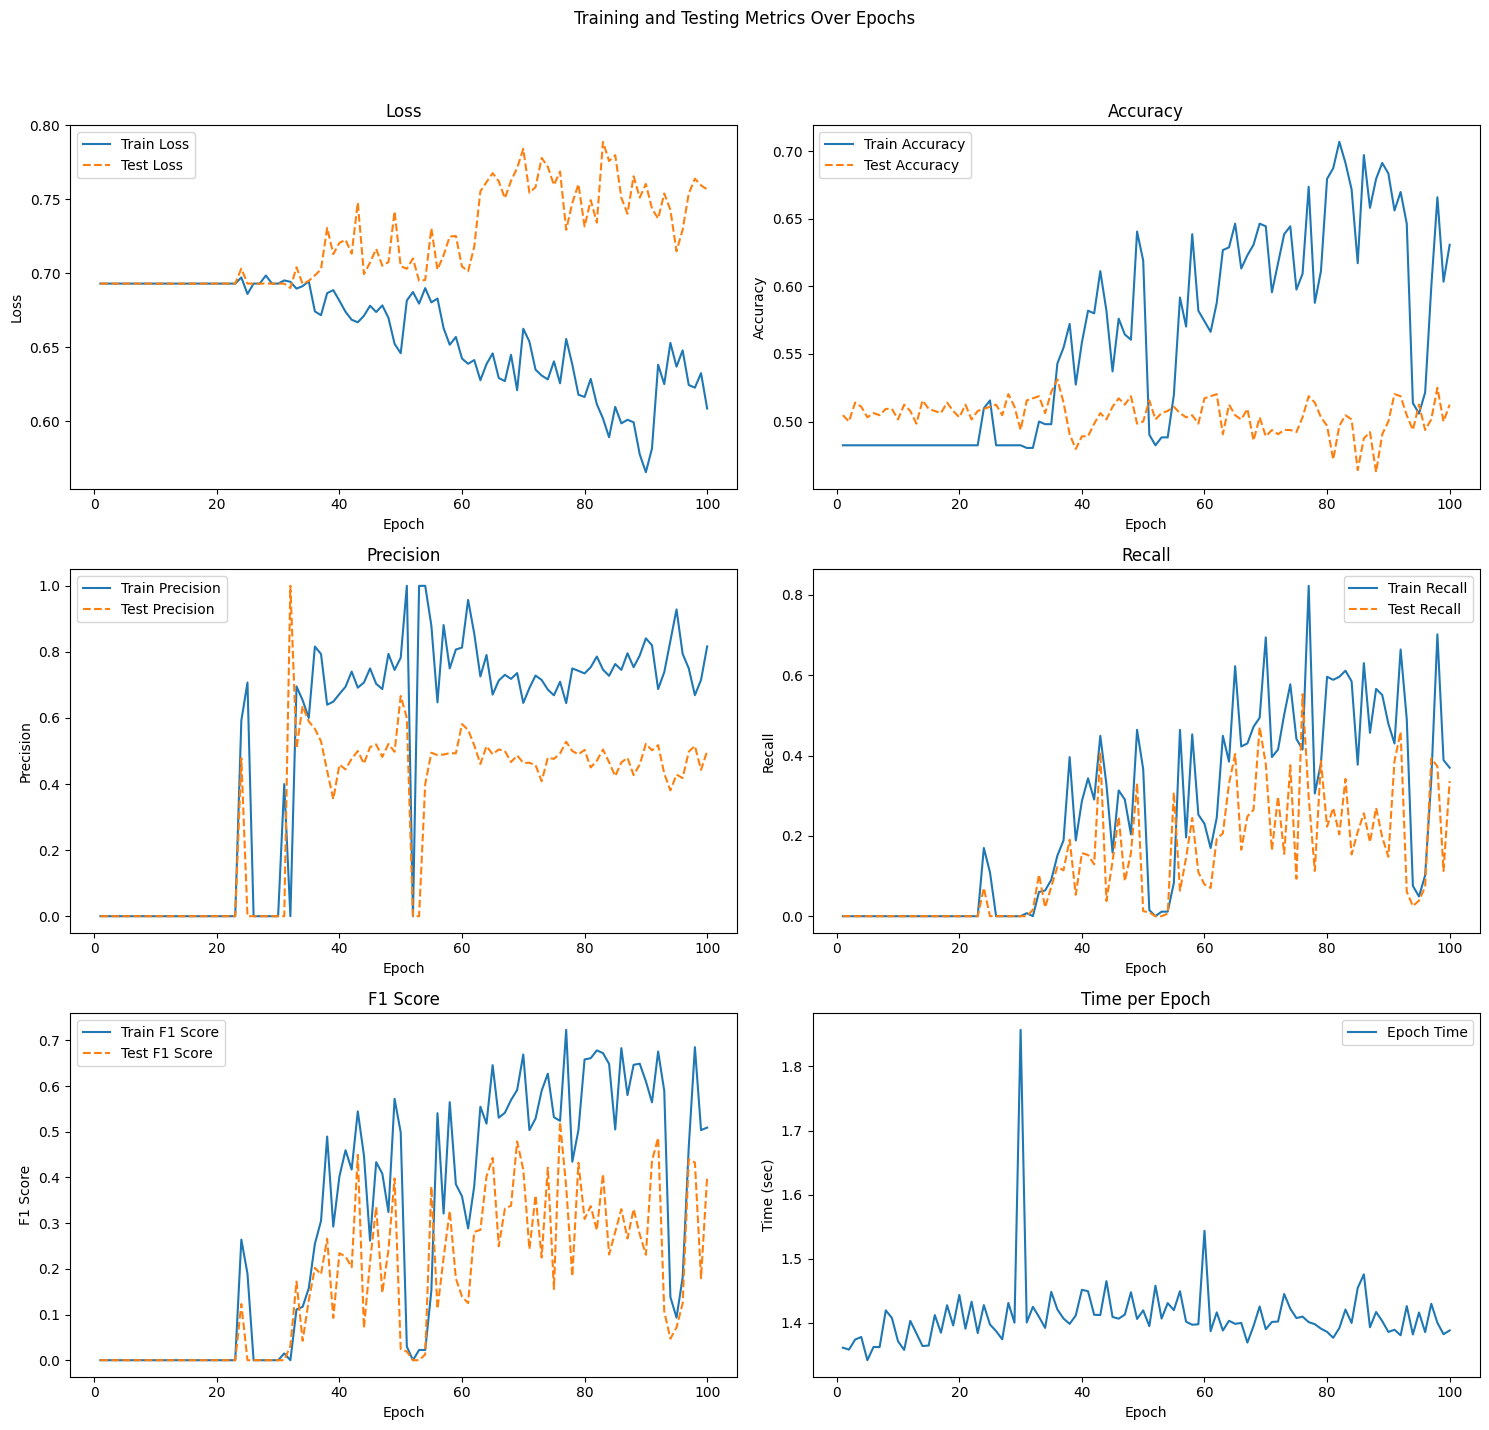

In [215]:
model = SNNCNN(embedding_matrix_tensor, 64, 32, 0.9).to(device)
criterion = SF.ce_rate_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999))
num_epochs = 100
num_steps = 100
df_metrics = train_test_SNN_metrics(model, criterion, optimizer, train_loader, test_loader, device, num_epochs, num_steps, population_code=False, num_classes=False, verbose=False)
plot_metrics(df_metrics)

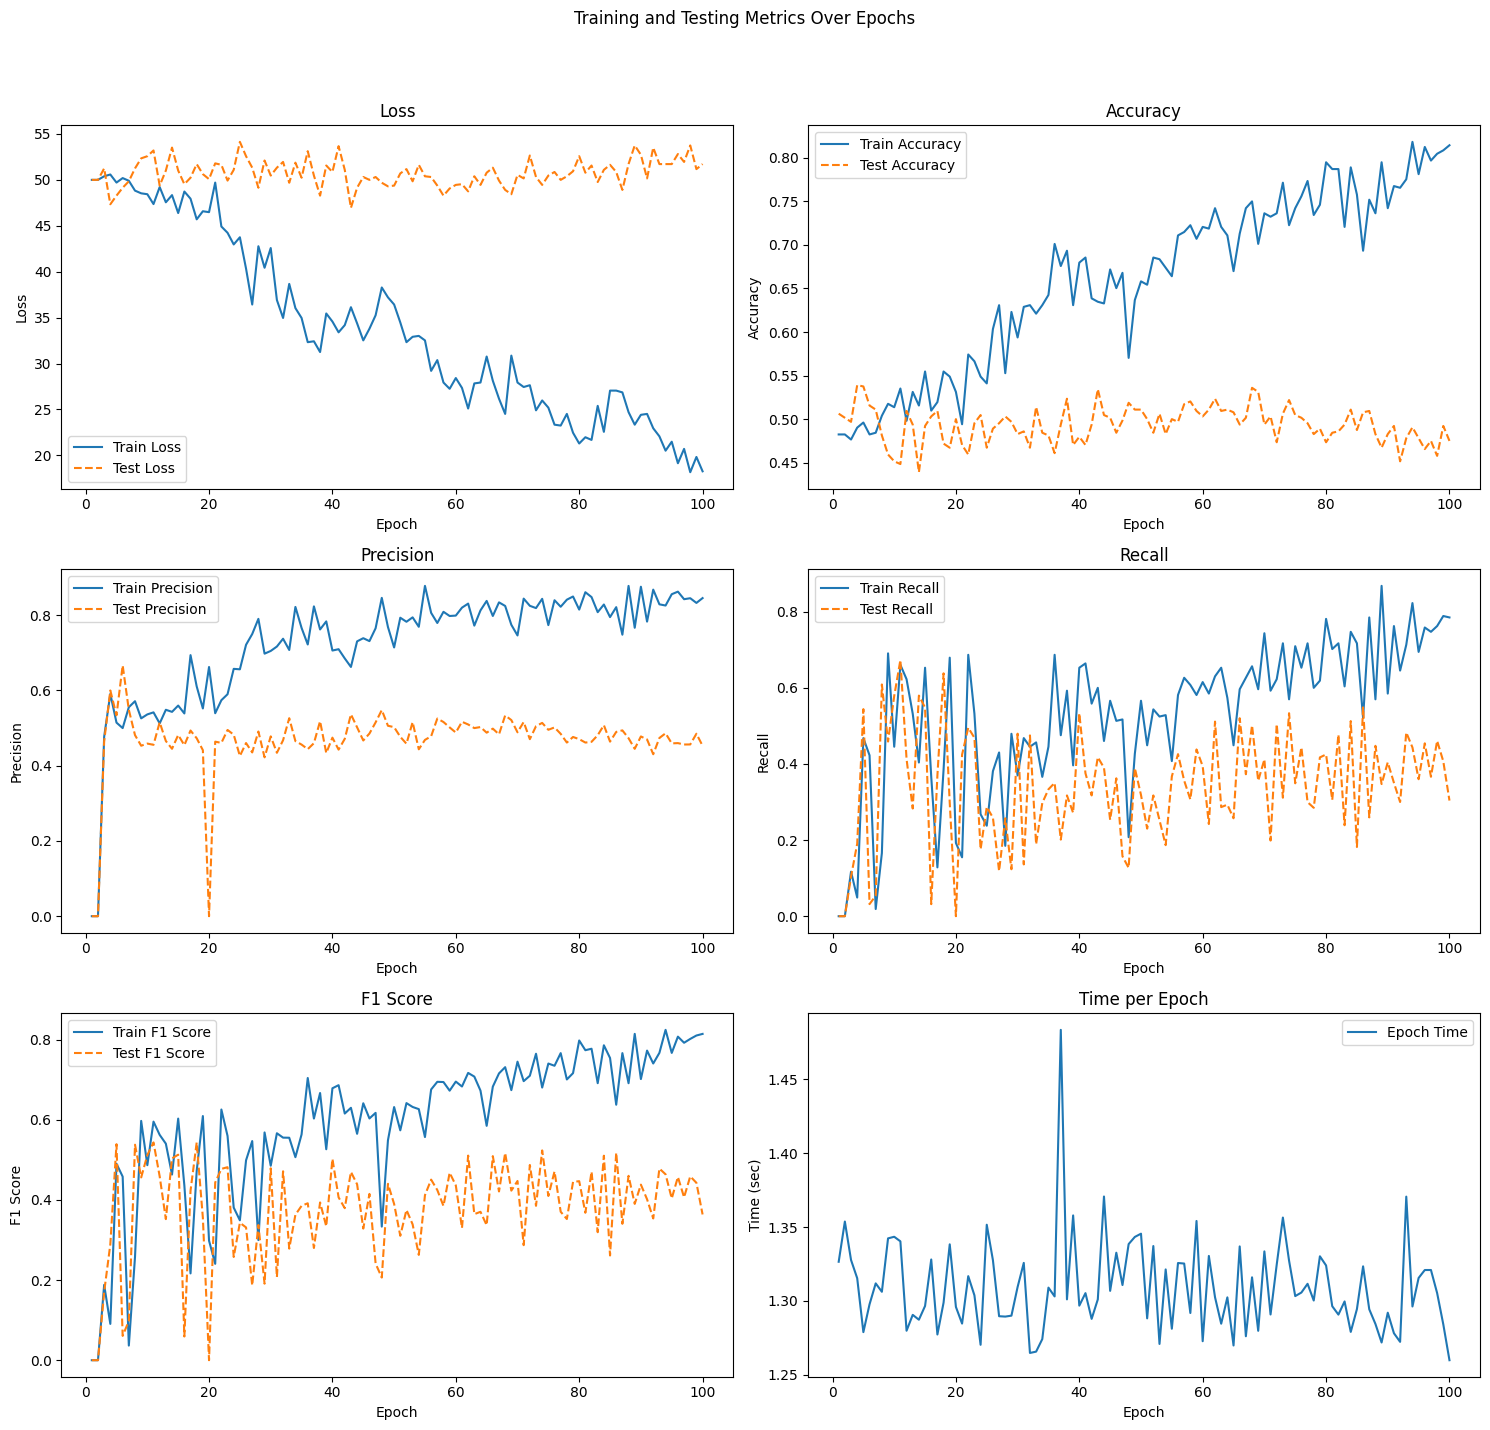

In [216]:
model = SNNCNN(embedding_matrix_tensor, 64, 32, 0.9).to(device)
criterion = SF.mse_count_loss(correct_rate=1.0, incorrect_rate=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999))
num_epochs = 100
num_steps = 100
df_metrics = train_test_SNN_metrics(model, criterion, optimizer, train_loader, test_loader, device, num_epochs, num_steps, population_code=False, num_classes=False, verbose=False)
plot_metrics(df_metrics)

In [222]:
class SNNCNN_pop(nn.Module):
    def __init__(self,embedding_matrix, hidden_layer1, hidden_layer2, beta = 0.9, population_size=10):
        super().__init__()
        spike_grad = surrogate.fast_sigmoid() # fast sigmoid surrogate gradient
        self.embeding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.conv1 = nn.Conv1d(embedding_matrix_tensor.size(1), hidden_layer1, 3)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv1d(hidden_layer1, hidden_layer2, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(96, 2 * population_size)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        x = self.embeding(x)
        x = x.transpose(1, 2).contiguous()

        cur1 = F.max_pool1d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool1d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)

        return spk3, mem3

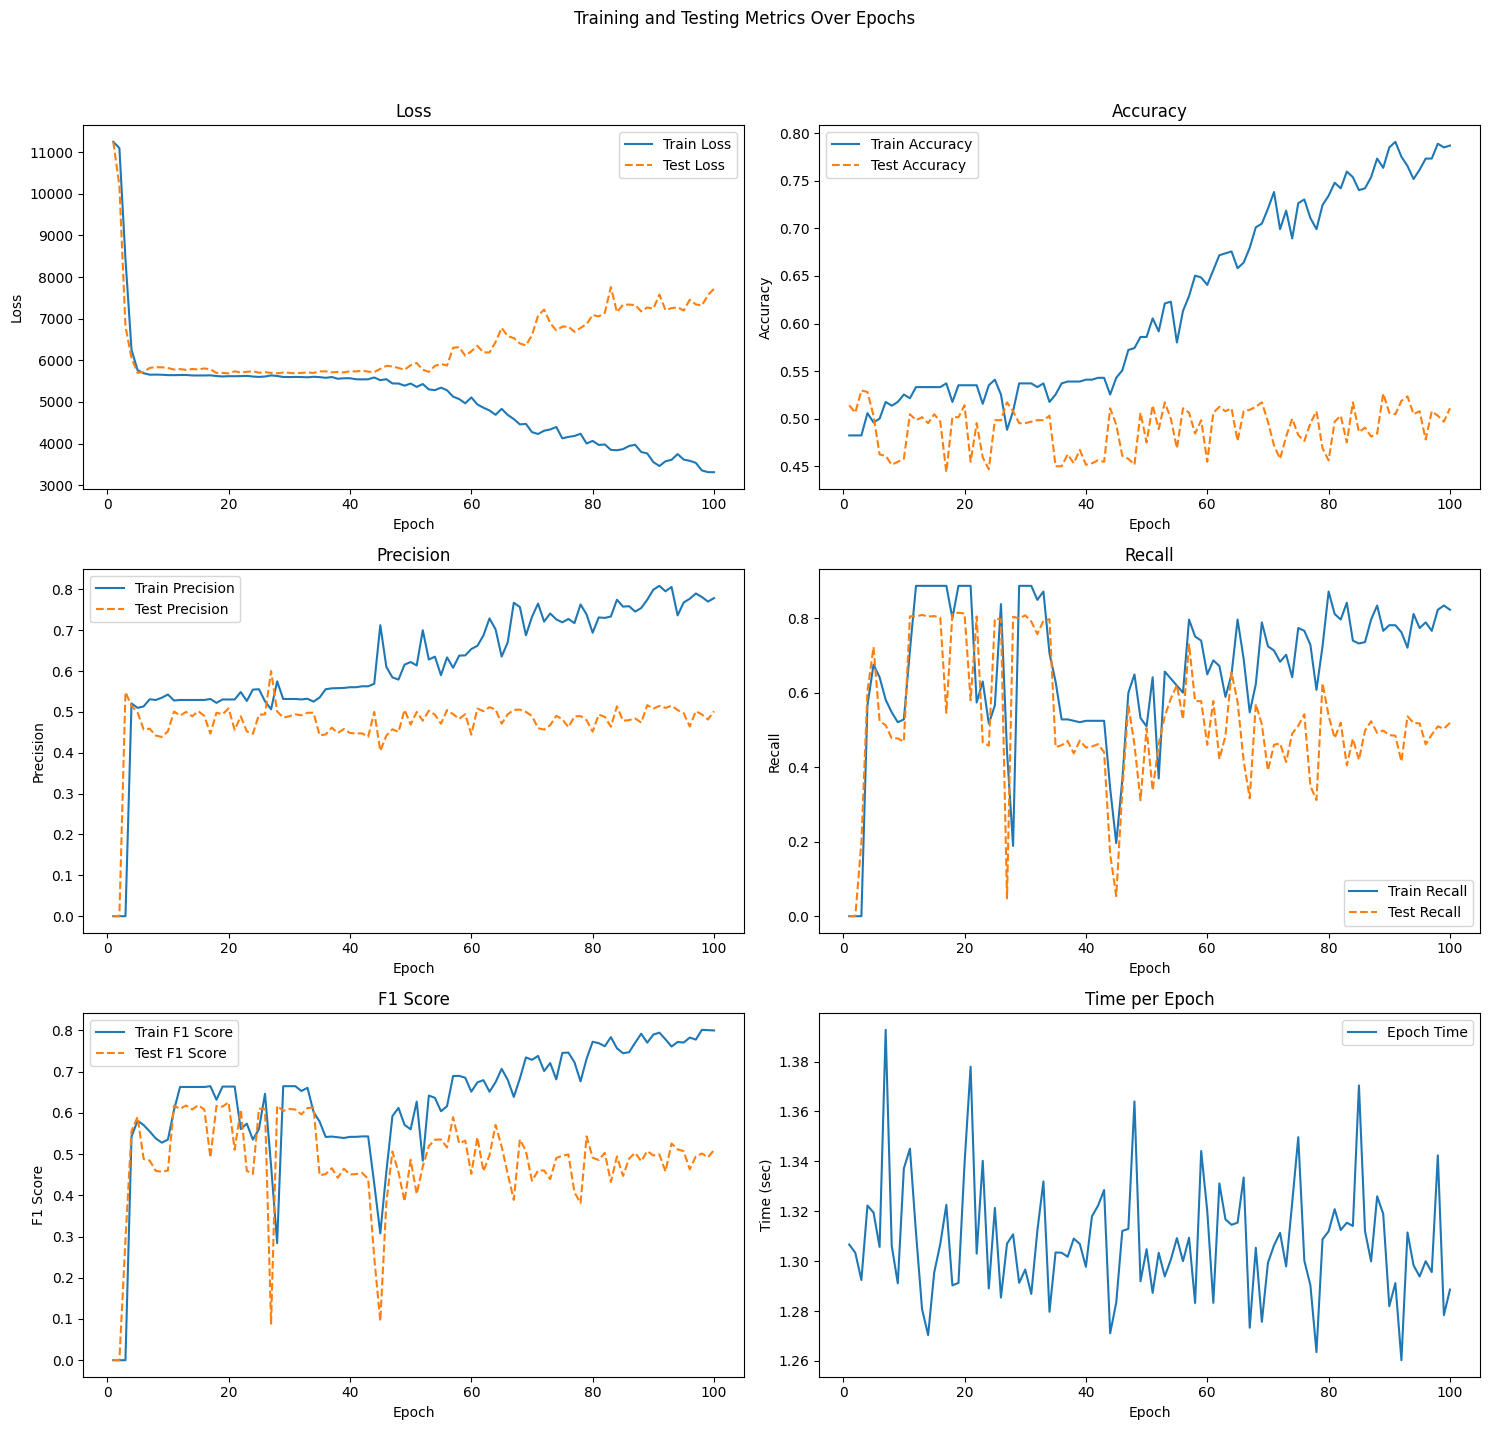

In [223]:
model = SNNCNN_pop(embedding_matrix_tensor, 64, 32, beta = 0.9, population_size=15).to(device)
criterion = SF.mse_count_loss(correct_rate=1.0, incorrect_rate=0.0, population_code=True, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999))
num_epochs = 100
num_steps = 100
df_metrics = train_test_SNN_metrics(model, criterion, optimizer, train_loader, test_loader, device, num_epochs, num_steps, population_code=True, num_classes=2, verbose=False)
plot_metrics(df_metrics)

In [235]:
class BiLSTM_SNN(nn.Module):
    def __init__(self,embedding_matrix, hidden_layer1, beta = 0.9):
        super().__init__()
        spike_grad_lstm = surrogate.straight_through_estimator()
        spike_grad = surrogate.fast_sigmoid()
        self.embeding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.slstm1 = snn.SLSTM(embedding_matrix.size(1), hidden_layer1, spike_grad=spike_grad_lstm)
        self.slstm2 = snn.SLSTM(embedding_matrix.size(1), hidden_layer1, spike_grad=spike_grad_lstm)
        self.fc1 = nn.Linear(25 * (hidden_layer1 * 2), 2)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        x = self.embeding(x)

        syn1, mem1 = self.slstm1.init_slstm()
        syn2, mem2 = self.slstm1.init_slstm()
        mem1 = self.lif1.init_leaky()

        output_spikes_forward = []
        output_spikes_backward = []
        for t in range(x.size(1)):  # seq_len dimension
            fwd_t = x[:, t, :]
            spk1, syn1, mem1 = self.slstm1(fwd_t, syn1, mem1)
            output_spikes_forward.append(spk1)
            bwd_t = x[:, (t+1)*-1, :]
            spk2, syn2, mem2 = self.slstm2(bwd_t, syn2, mem2)
            output_spikes_backward.append(spk2)

        output_spikes_forward = torch.stack(output_spikes_forward, dim=1)
        output_spikes_backward = torch.stack(output_spikes_backward, dim=1)
        output_spikes = torch.cat((output_spikes_forward, output_spikes_backward), dim=2)
        output_spike = output_spikes.view(batch_size, -1) 
        cur3 = self.fc1(output_spike)
        spk3, mem3 = self.lif1(cur3, mem1)
        return cur3, mem2

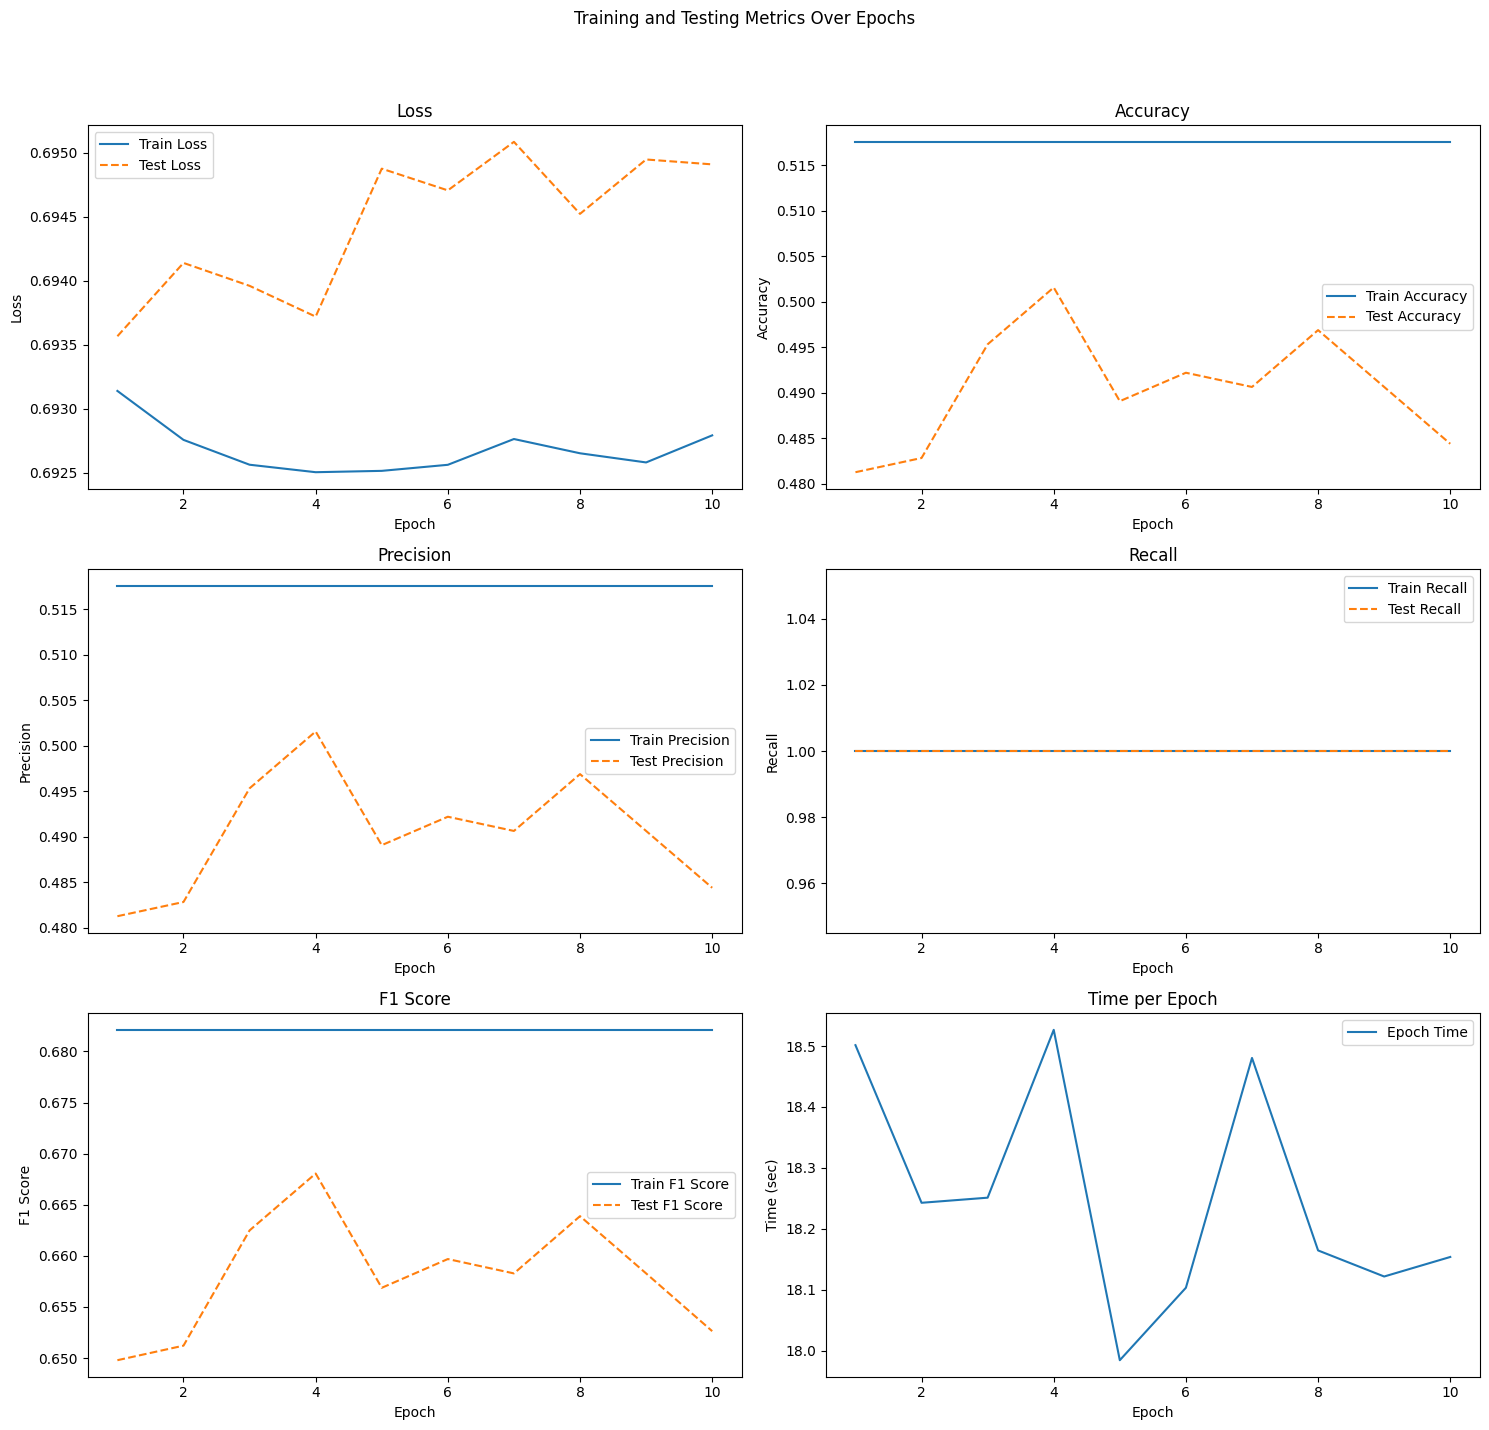

In [237]:
model = BiLSTM_SNN(embedding_matrix_tensor, 64).to(device)
criterion = SF.ce_rate_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=7e-3, betas=(0.9, 0.999))
num_epochs = 10
num_steps = 100
df_metrics = train_test_SNN_metrics(model, criterion, optimizer, train_loader, test_loader, device, num_epochs, num_steps, population_code=False, num_classes=False, verbose=False)
plot_metrics(df_metrics)

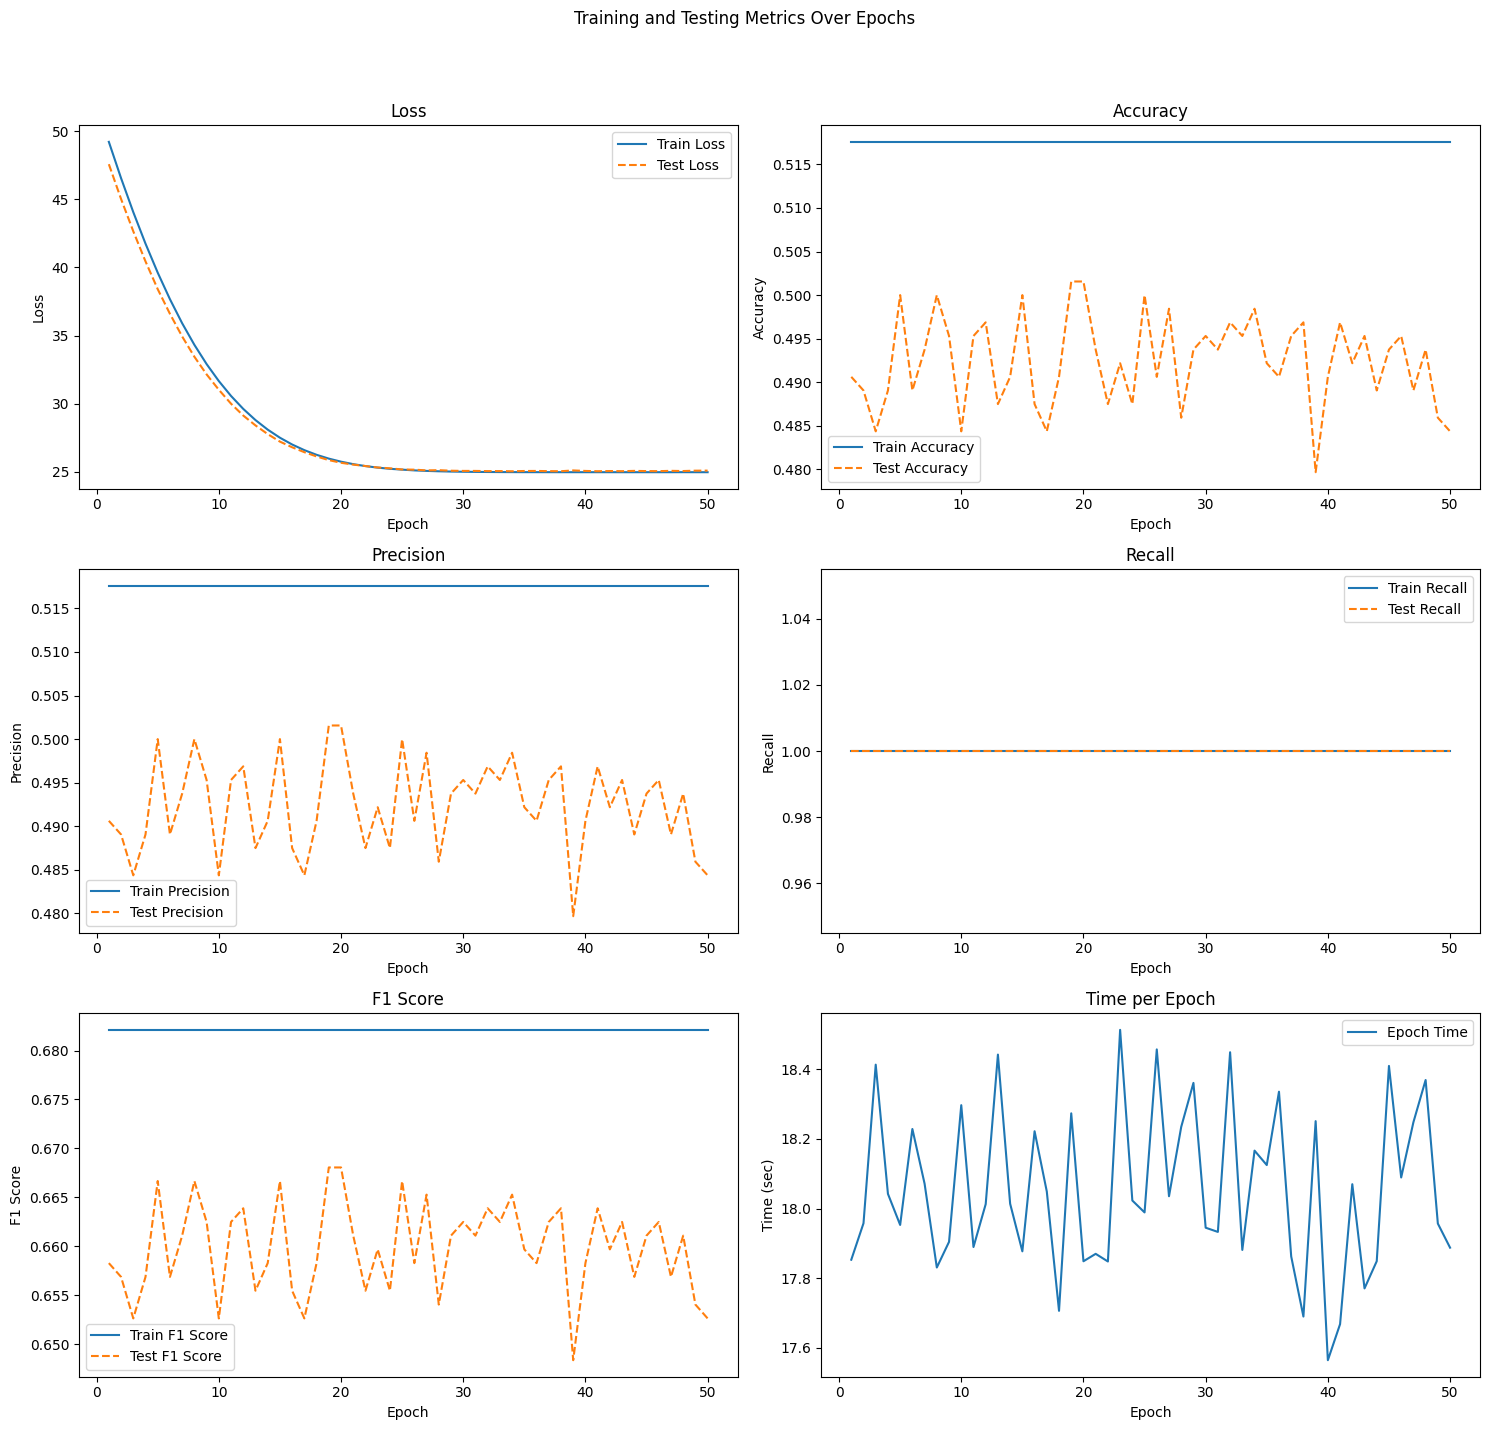

In [239]:
model = BiLSTM_SNN(embedding_matrix_tensor, 64).to(device)
criterion = SF.mse_count_loss(correct_rate=1.0, incorrect_rate=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=7e-3, betas=(0.9, 0.999))
num_epochs = 50
num_steps = 100
df_metrics = train_test_SNN_metrics(model, criterion, optimizer, train_loader, test_loader, device, num_epochs, num_steps, population_code=False, num_classes=False, verbose=False)
plot_metrics(df_metrics)

In [244]:
class BiLSTM_SNN_pop(nn.Module):
    def __init__(self,embedding_matrix, hidden_layer1, beta = 0.9, population_size=10):
        super().__init__()
        spike_grad_lstm = surrogate.straight_through_estimator()
        spike_grad = surrogate.fast_sigmoid()
        self.embeding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.slstm1 = snn.SLSTM(embedding_matrix.size(1), hidden_layer1, spike_grad=spike_grad_lstm)
        self.slstm2 = snn.SLSTM(embedding_matrix.size(1), hidden_layer1, spike_grad=spike_grad_lstm)
        self.fc1 = nn.Linear(25 * (hidden_layer1 * 2), 2*population_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        x = self.embeding(x)

        syn1, mem1 = self.slstm1.init_slstm()
        syn2, mem2 = self.slstm1.init_slstm()
        mem1 = self.lif1.init_leaky()

        output_spikes_forward = []
        output_spikes_backward = []
        for t in range(x.size(1)):  # seq_len dimension
            fwd_t = x[:, t, :]
            spk1, syn1, mem1 = self.slstm1(fwd_t, syn1, mem1)
            output_spikes_forward.append(spk1)
            bwd_t = x[:, (t+1)*-1, :]
            spk2, syn2, mem2 = self.slstm2(bwd_t, syn2, mem2)
            output_spikes_backward.append(spk2)

        output_spikes_forward = torch.stack(output_spikes_forward, dim=1)
        output_spikes_backward = torch.stack(output_spikes_backward, dim=1)
        output_spikes = torch.cat((output_spikes_forward, output_spikes_backward), dim=2)
        output_spike = output_spikes.view(batch_size, -1) 
        cur3 = self.fc1(output_spike)
        spk3, mem3 = self.lif1(cur3, mem1)
        return spk3, mem3

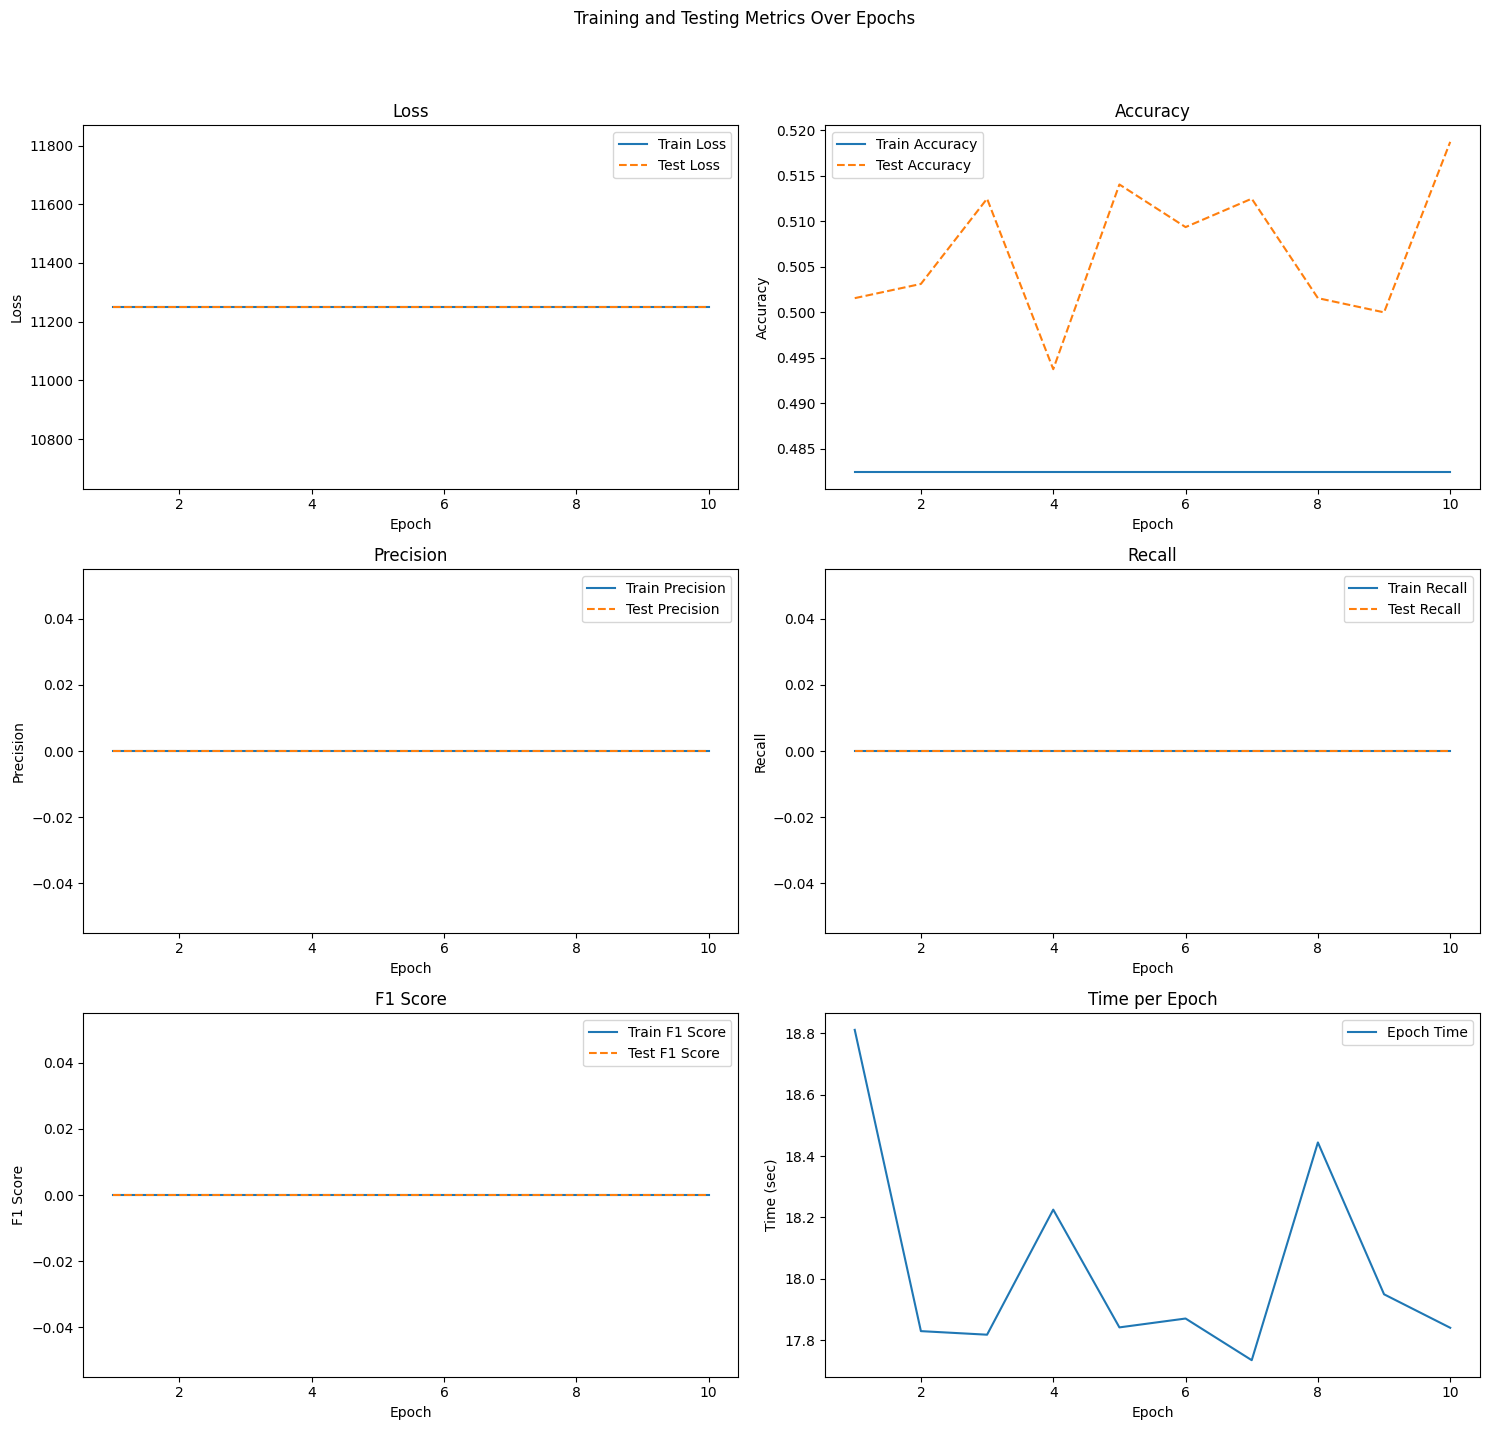

In [245]:
model = BiLSTM_SNN_pop(embedding_matrix_tensor, 64, beta = 0.9, population_size=15).to(device)
criterion = SF.mse_count_loss(correct_rate=1.0, incorrect_rate=0.0, population_code=True, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999))
num_epochs = 10
num_steps = 100
df_metrics = train_test_SNN_metrics(model, criterion, optimizer, train_loader, test_loader, device, num_epochs, num_steps, population_code=True, num_classes=2, verbose=False)
plot_metrics(df_metrics)

In [275]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.query_layer = nn.Linear(hidden_size, hidden_size)
        self.key_layer = nn.Linear(hidden_size, hidden_size)
        self.value_layer = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        # x is expected to be of shape [seq_len, batch_size, hidden_size]
        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)

        # Compute attention scores
        scores = torch.bmm(query.transpose(0, 1), key.transpose(0, 1).transpose(1, 2)) / (query.size(2) ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)

        # Apply attention weights to values
        attended = torch.bmm(attn_weights, value.transpose(0, 1))

        return attended        # x is expected to be of shape [seq_len, batch_size, hidden_size]


class SNNCNN_attention(nn.Module):
    def __init__(self,embedding_matrix, hidden_layer1, hidden_layer2, beta = 0.9):
        super().__init__()
        spike_grad = surrogate.fast_sigmoid() # fast sigmoid surrogate gradient
        self.embeding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.conv1 = nn.Conv1d(embedding_matrix.size(1), hidden_layer1, 3)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv1d(hidden_layer1, hidden_layer2, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(96, 2)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.attention1 = AttentionLayer(embedding_matrix.size(1))
        self.attention2 = AttentionLayer(11)
        self.attention3 = AttentionLayer(3)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        x = self.embeding(x)
        x = x.transpose(0, 1).contiguous()
        x = self.attention1(x)
        x = x.transpose(1, 2).contiguous()
        cur1 = F.max_pool1d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)
        spk1 = spk1.transpose(0, 1).contiguous()
        spk1 = self.attention2(spk1)
        cur2 = F.max_pool1d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)
        spk2 = spk2.transpose(0, 1).contiguous()
        spk2 = self.attention3(spk2)
        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)
        return spk3, mem3

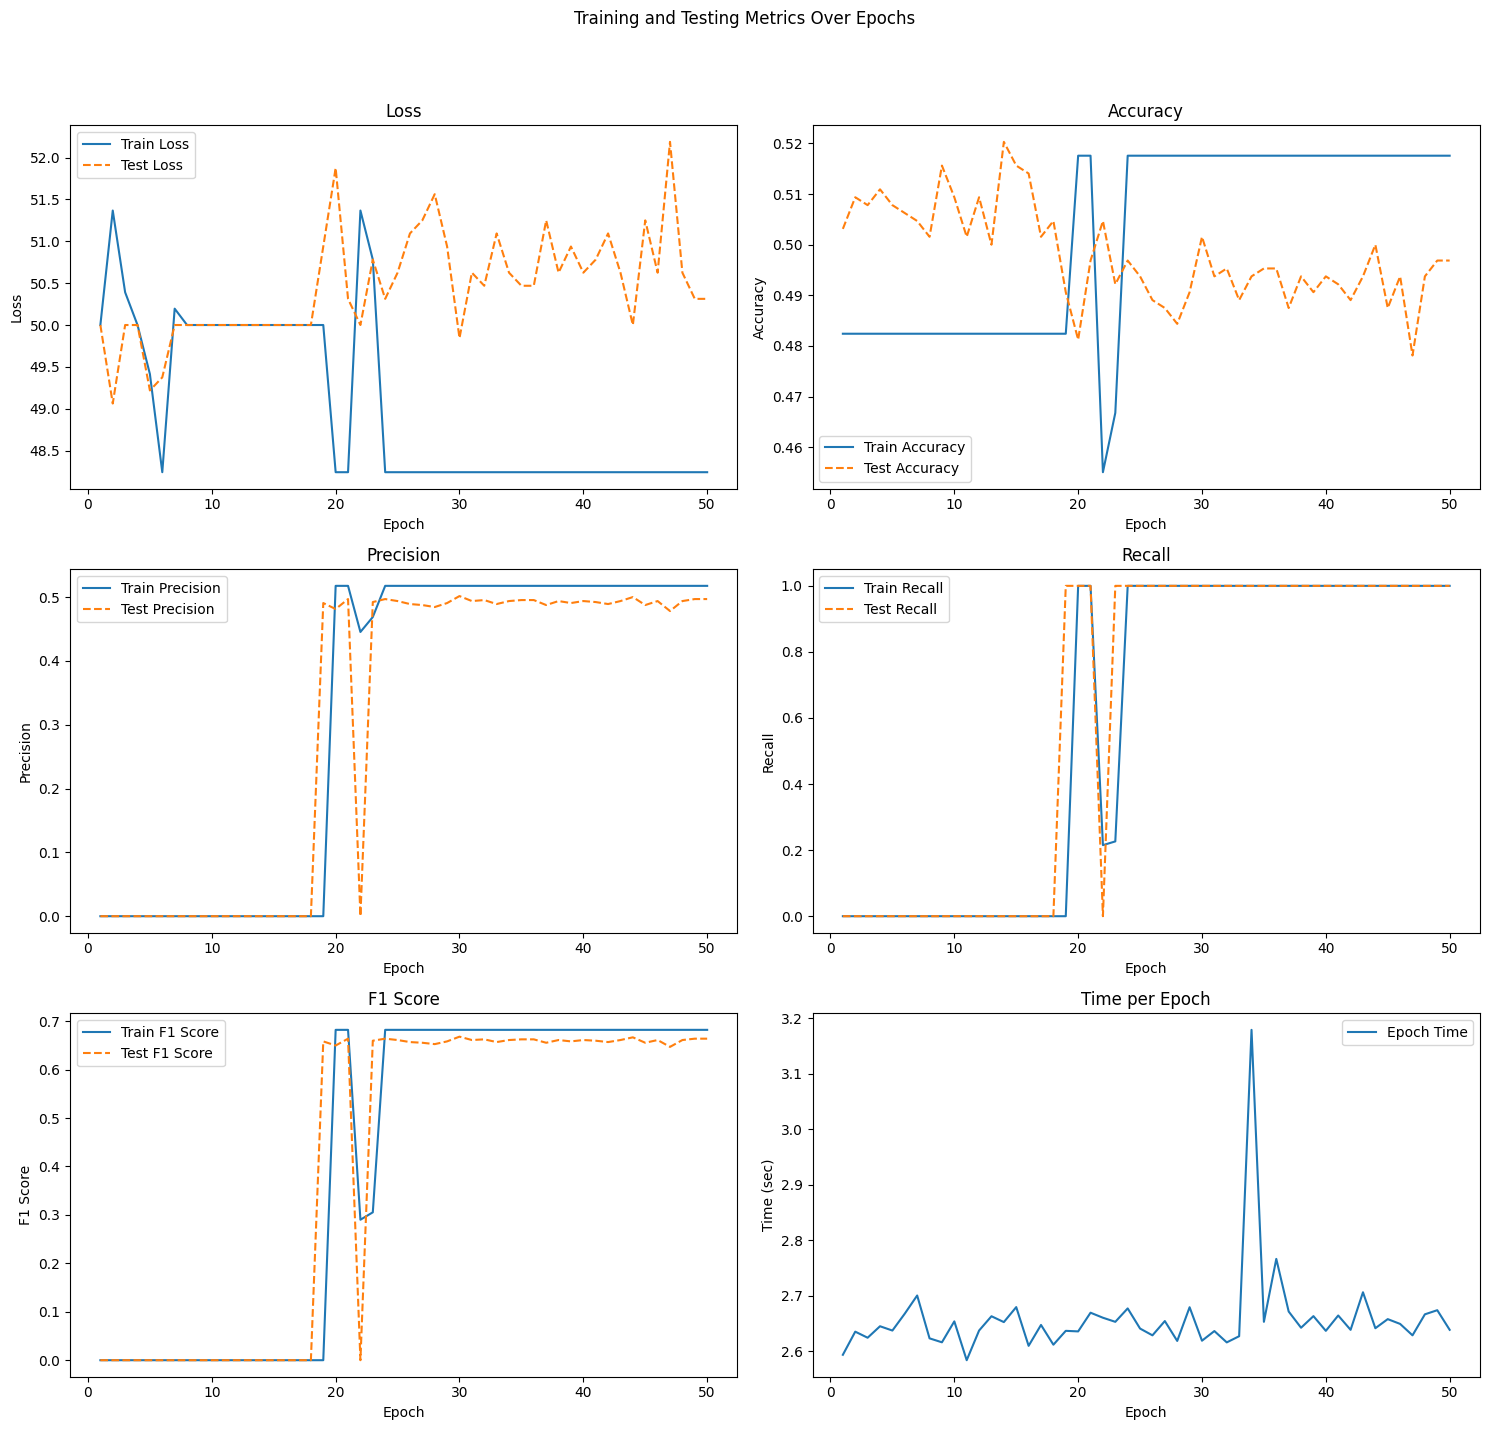

In [278]:
model = SNNCNN_attention(embedding_matrix_tensor, 64, 32, 0.9).to(device)
criterion = SF.mse_count_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999))
num_epochs = 50
num_steps = 100
df_metrics = train_test_SNN_metrics(model, criterion, optimizer, train_loader, test_loader, device, num_epochs, num_steps, population_code=False, num_classes=False, verbose=False)
plot_metrics(df_metrics)

In [287]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, beta, slope):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            snn.Leaky(beta=beta, spike_grad=snn.surrogate.fast_sigmoid(slope)),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.leaky_activation = snn.Leaky(beta=beta, spike_grad=snn.surrogate.fast_sigmoid(slope))
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(query, key, value, attn_mask=mask)[0]
        x = self.dropout(self.norm1(attention + query))
        
        ffn_input = self.feed_forward[0](x)
        mem = self.leaky_activation.init_leaky()
        ffn_output, mem = self.leaky_activation(self.feed_forward[1](ffn_input), mem)
        out = self.dropout(self.norm2(ffn_output + x))
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=25):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)
        
        self.register_buffer('pe', self.encoding)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


class DecoderWithPositionalEncoding(nn.Module):
    def __init__(self, pretrained_embeddings, num_layers, heads=2, forward_expansion=16, dropout=0.6, max_length=25, beta=0.9, slope=25):
        super(DecoderWithPositionalEncoding, self).__init__()
        # Initialize embedding layer with pre-trained embeddings
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.decoder_layers = nn.ModuleList(
            [TransformerBlock(pretrained_embeddings.size(1), heads, dropout, forward_expansion, beta, slope) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)
        self.positional_encoding = PositionalEncoding(pretrained_embeddings.size(1), max_length)

    def forward(self, x, enc_out=None, src_mask=None, trg_mask=None):
        # Convert input tokens to embeddings
        x = self.embedding(x)  # Shape: (N, seq_length, embed_size)
        N, seq_length, _ = x.shape
        # Apply positional encoding
        x = self.positional_encoding(x)
        x = self.dropout(x)

        for layer in self.decoder_layers:
            x = layer(x, x, x, trg_mask)

        return x



In [289]:
# model = DecoderWithPositionalEncoding(embedding_matrix_tensor, 2).to(device)
# criterion = SF.mse_count_loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999))
# num_epochs = 50
# num_steps = 100
# df_metrics = train_test_SNN_metrics(model, criterion, optimizer, train_loader, test_loader, device, num_epochs, num_steps, population_code=False, num_classes=False, verbose=False)
# plot_metrics(df_metrics)

In [429]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

class MetricsLogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = {
            'Epoch': [],
            'Train Loss': [],
            'Train Accuracy': [],
            'Train Precision': [],
            'Train Recall': [],
            'Train F1 Score': [],
            'Test Loss': [],
            'Test Accuracy': [],
            'Test Precision': [],
            'Test Recall': [],
            'Test F1 Score': [],
            'Epoch Time': []
        }
        self.start_time = None

    def on_train_epoch_start(self, trainer, pl_module):
        self.start_time = time.time()

    def on_train_epoch_end(self, trainer, pl_module, outputs=None):
        epoch_time = time.time() - self.start_time
        self.metrics['Epoch Time'].append(epoch_time)
        self.metrics['Epoch'].append(trainer.current_epoch + 1)  # Epochs are zero-indexed

        # Assuming you are logging these values in your training step
        train_loss = trainer.callback_metrics['train_loss'].item()
        train_acc = trainer.callback_metrics['train_acc'].item()
        train_prec = trainer.callback_metrics['train_prec'].item()
        train_recall = trainer.callback_metrics['train_recall'].item()
        train_f1 = trainer.callback_metrics['train_f1'].item()

        self.metrics['Train Loss'].append(train_loss)
        self.metrics['Train Accuracy'].append(train_acc)
        self.metrics['Train Precision'].append(train_prec)
        self.metrics['Train Recall'].append(train_recall)
        self.metrics['Train F1 Score'].append(train_f1)
        

    def on_validation_epoch_end(self, trainer, pl_module):
        # Assuming you are logging these values in your test step
        test_loss = trainer.callback_metrics['test_loss'].item()
        test_acc = trainer.callback_metrics['test_acc'].item()
        test_prec = trainer.callback_metrics['test_prec'].item()
        test_recall = trainer.callback_metrics['test_recall'].item()
        test_f1 = trainer.callback_metrics['test_f1'].item()
        self.metrics['Test Loss'].append(test_loss)
        self.metrics['Test Accuracy'].append(test_acc)
        self.metrics['Test Precision'].append(test_prec)
        self.metrics['Test Recall'].append(test_recall)
        self.metrics['Test F1 Score'].append(test_f1)

    def compile_metrics(self):    
        if len(self.metrics['Test Loss'])>len(self.metrics['Epoch']):
            self.metrics['Test Loss'] = self.metrics['Test Loss'][1:]
            self.metrics['Test Accuracy'] = self.metrics['Test Accuracy'][1:]
            self.metrics['Test Precision'] = self.metrics['Test Precision'][1:]
            self.metrics['Test Recall'] = self.metrics['Test Recall'][1:]
            self.metrics['Test F1 Score'] = self.metrics['Test F1 Score'][1:]

        return pd.DataFrame(self.metrics)


^C
ERROR: Operation cancelled by user


In [384]:
class SequenceLearner(pl.LightningModule):
    def __init__(self,embedding_matrix, hidden_feat=16, lr=0.005):
        super().__init__()
        wiring = AutoNCP(hidden_feat, 2)  # 16 units, 1 motor neuron
        self.model = LTC(embedding_matrix.size(1), wiring, batch_first=True)
        self.lr = lr
        self.embeding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.loss_fn = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss
        self.final_linear = nn.Linear(50, 1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        y = y.float() 
        y_hat = y_hat.view_as(y)
        loss = self.loss_fn(y_hat, y)  # Calculate BCE loss
        self.log("train_loss", loss, prog_bar=True)
        
        y_hat_bin = torch.sigmoid(y_hat) > 0.5  # Convert to binary predictions
        acc = accuracy_score(y.cpu(), y_hat_bin.cpu())
        prec = precision_score(y.cpu(), y_hat_bin.cpu(), zero_division=0)
        rec = recall_score(y.cpu(), y_hat_bin.cpu(), zero_division=0)
        f1 = f1_score(y.cpu(), y_hat_bin.cpu(), zero_division=0)

        self.log("train_acc", acc, prog_bar=True)
        self.log("train_prec", prec, prog_bar=True)
        self.log("train_recall", rec, prog_bar=True)
        self.log("train_f1", f1, prog_bar=True)
        return {"loss": loss, "train_acc": acc, "train_prec": prec, "train_recall": rec, "train_f1": f1}
    
    def forward(self, x):
        x = self.embeding(x)
        y_hat, _ = self.model.forward(x)
        y_hat_flat = y_hat.view(y_hat.size(0), -1)  # New shape: [batch_size, sequence_length * num_features]
        output = self.final_linear(y_hat_flat)  # New shape: [batch_size, output_features]
        
        return output
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        y_hat = y_hat.view_as(y)
        y = y.float() 
        loss = self.loss_fn(y_hat, y)  # Calculate BCE loss
        self.log("test_loss", loss, prog_bar=True)
        
        y_hat_bin = torch.sigmoid(y_hat) > 0.5  # Convert to binary predictions
        acc = accuracy_score(y.cpu(), y_hat_bin.cpu())
        prec = precision_score(y.cpu(), y_hat_bin.cpu(), zero_division=0)
        rec = recall_score(y.cpu(), y_hat_bin.cpu(), zero_division=0)
        f1 = f1_score(y.cpu(), y_hat_bin.cpu(), zero_division=0)

        self.log("test_acc", acc, prog_bar=True)
        self.log("test_prec", prec, prog_bar=True)
        self.log("test_recall", rec, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)

        return {"val_loss": loss, "val_acc": acc, "val_prec": prec, "val_rec": rec, "val_f1": f1}


    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [434]:
learn = SequenceLearner(embedding_matrix_tensor,64, lr=0.005)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=30,callbacks=[MetricsLogger()],
    gradient_clip_val=1,  # Clip gradient to stabilize training
)
trainer.fit(learn, train_loader,test_loader)


alloc!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

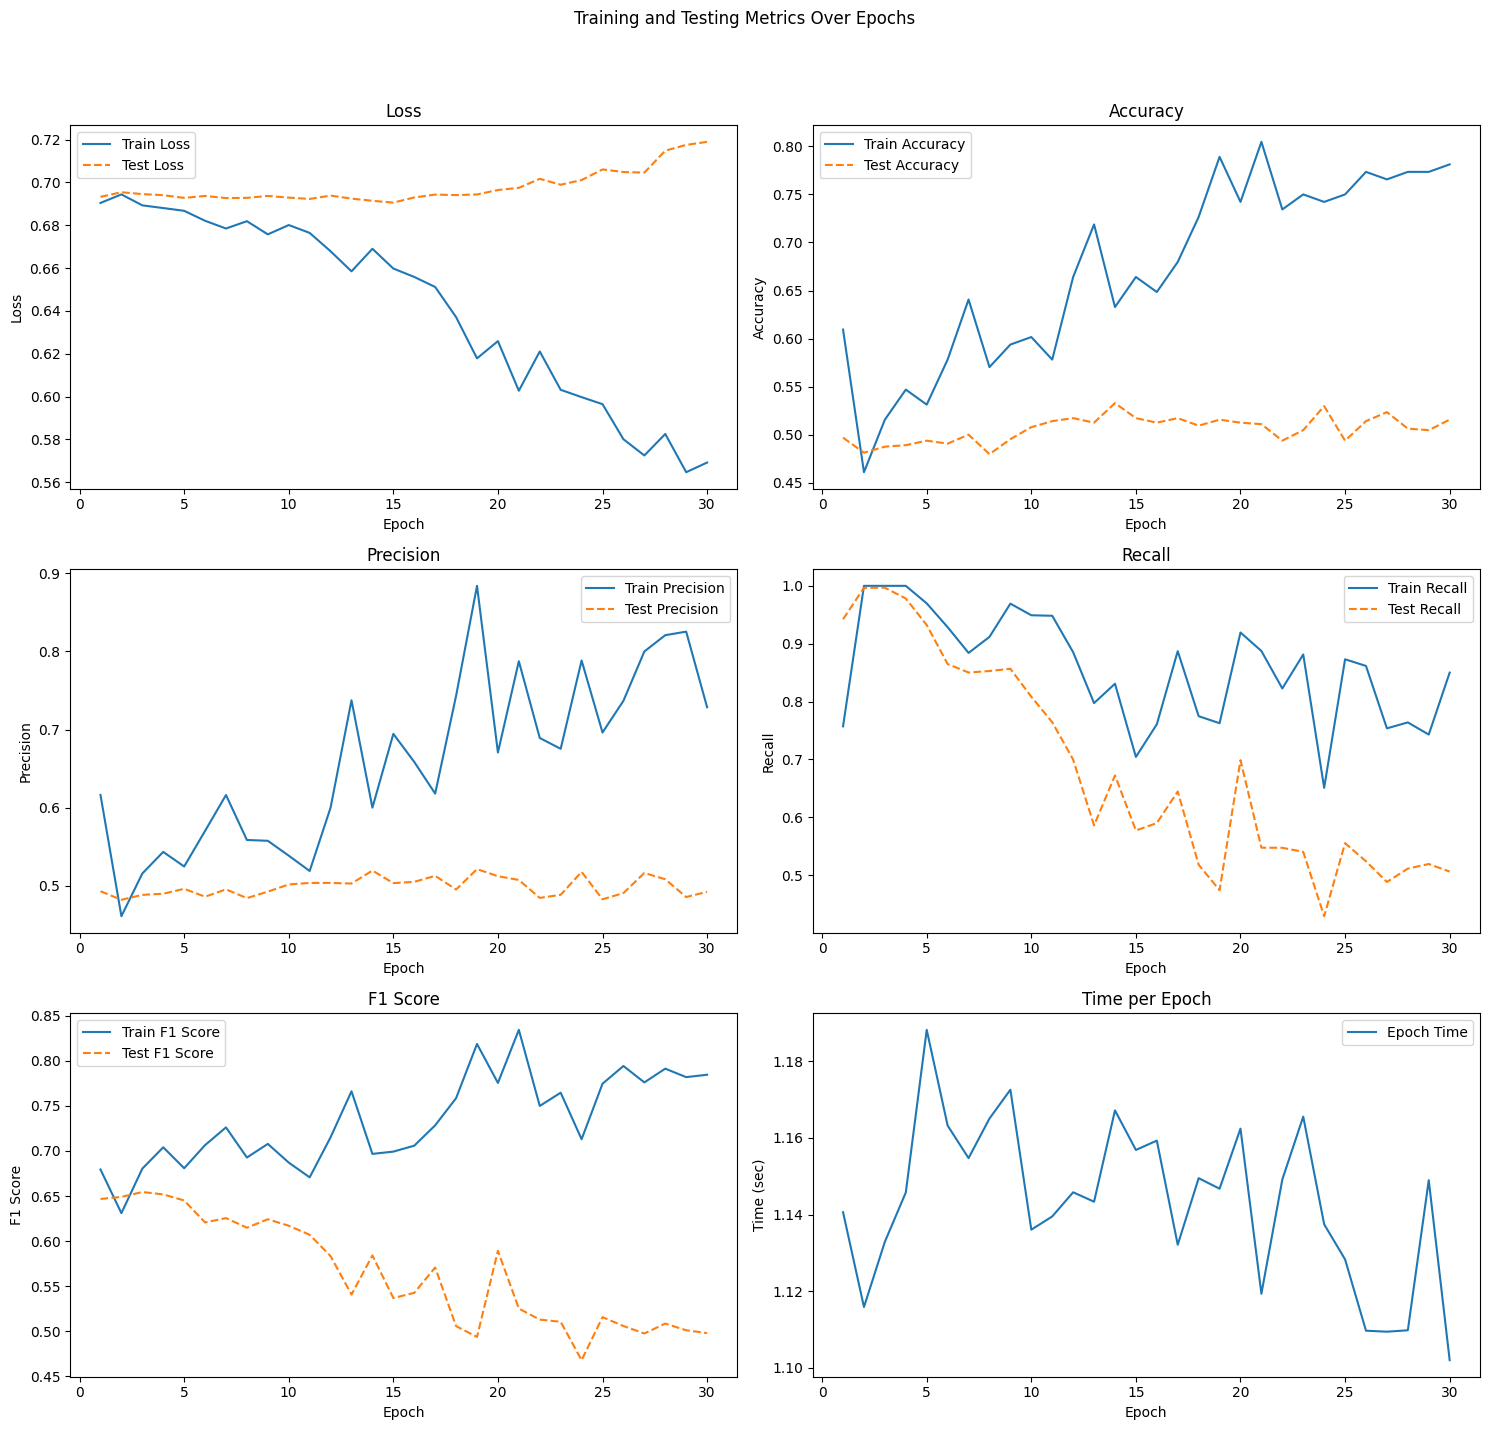

In [436]:
metrics_logger = trainer.callbacks[0]  # Assuming MetricsLogger is the first callback
metrics_df = metrics_logger.compile_metrics()
plot_metrics(metrics_df)

In [74]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(2501)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available() :
    embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float).to(device)
    model = TextESNClassifier2(embedding_matrix_tensor, hidden_size=128,esn1_output_size=64, num_classes=2, washout=30).to(device)


batch_size=128
num_epochs=30

# X_train_tensor = torch.tensor(X_train, dtype=torch.long)
# X_train_labels_tensor = torch.tensor(dfTrain["Label"].values, dtype=torch.long)
# train_dataset = TensorDataset(X_train_tensor, X_train_labels_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

X_train_tensor = torch.tensor(X_test[:512], dtype=torch.long)
X_train_labels_tensor = torch.tensor(dfTest["Label"].values[:512], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, X_train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
X_test_tensor = torch.tensor(X_test[512:], dtype=torch.long)
X_test_labels_tensor = torch.tensor(dfTest["Label"].values[512:], dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, X_test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# X_test_tensor = torch.tensor(X_test, dtype=torch.long)
# X_test_labels_tensor = torch.tensor(dfTest["Label"].values, dtype=torch.long)
# test_dataset = TensorDataset(X_test_tensor, X_test_labels_tensor)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
for epoch in range(num_epochs):  # num_epochs is the number of epochs you want to train for
    model.train()
    for inputs, labels in train_loader:  # train_loader is your DataLoader for training data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Get model predictions
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total



    # Testing loop
    model.eval()

    total_correct = 0
    total_samples = 0
    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:  # test_loader is your DataLoader for testing data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    test_accuracy = total_correct / total_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Train Accuracy: {accuracy*100:.2f}%, Test Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/30, Loss: 0.6935389041900635, Train Accuracy: 49.22%, Test Accuracy: 48.59%
Epoch 2/30, Loss: 0.6836104989051819, Train Accuracy: 53.91%, Test Accuracy: 47.81%
Epoch 3/30, Loss: 0.6750436425209045, Train Accuracy: 67.97%, Test Accuracy: 47.19%
Epoch 4/30, Loss: 0.6652552485466003, Train Accuracy: 63.28%, Test Accuracy: 47.03%
Epoch 5/30, Loss: 0.6675989627838135, Train Accuracy: 61.72%, Test Accuracy: 46.09%
Epoch 6/30, Loss: 0.6390732526779175, Train Accuracy: 69.53%, Test Accuracy: 48.59%
Epoch 7/30, Loss: 0.6465898156166077, Train Accuracy: 65.62%, Test Accuracy: 47.97%
Epoch 8/30, Loss: 0.6295616030693054, Train Accuracy: 65.62%, Test Accuracy: 50.31%
Epoch 9/30, Loss: 0.5943083763122559, Train Accuracy: 73.44%, Test Accuracy: 47.81%
Epoch 10/30, Loss: 0.5620845556259155, Train Accuracy: 73.44%, Test Accuracy: 49.22%
Epoch 11/30, Loss: 0.5725904107093811, Train Accuracy: 68.75%, Test Accuracy: 47.97%
Epoch 12/30, Loss: 0.5140346884727478, Train Accuracy: 78.12%, Test Accura

In [231]:
!pip install tensorflow-gpu==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.5 MB/s eta 0:00:00:00:010:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 1.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 261.4 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 16.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 94.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 45.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-a

In [272]:


import tensorflow as tf
from tensorflow import keras
import numpy as np

def sparse_eye(M):
    
    #Generates an M x M matrix to be used as sparse identity matrix for the 
    #re-scaling of the sparse recurrent kernel in presence of non-zero leakage.
    #All the non-zero elements are set to 1
    dense_shape = (M,M)

    #gives the shape of a ring matrix:
    indices = np.zeros((M,2))
    for i in range(M):
        indices[i,:] = [i,i]
    values = np.ones(shape = (M,)).astype('f')

    W = (tf.sparse.reorder(tf.SparseTensor(indices = indices, values = values, dense_shape = dense_shape)))
    return W

def sparse_tensor(M,N, C = 1):
    #Generates an M x N matrix to be used as sparse (input) kernel
    #For each row only C elements are non-zero
    #(i.e., each input dimension is projected only to C neurons).
    #The non-zero elements are generated randomly from a uniform distribution in [-1,1]

    dense_shape = (M,N) #the shape of the dense version of the matrix

    indices = np.zeros((M * C,2)) #indices of non-zero elements initialization
    k = 0
    for i in range(M):
        #the indices of non-zero elements in the i-th row of the matrix
        idx =np.random.choice(N,size = C,replace = False)
        for j in range(C):
            indices[k,:] = [i,idx[j]]
            k = k + 1
    values = 2*(2*np.random.rand(M*C).astype('f')-1)
    W = (tf.sparse.reorder(tf.SparseTensor(indices = indices, values = values, dense_shape = dense_shape)))
    return W


def sparse_recurrent_tensor(M, C = 1):
    #Generates an M x M matrix to be used as sparse recurrent kernel
    #For each column only C elements are non-zero
    #(i.e., each recurrent neuron take sinput from C other recurrent neurons).
    #The non-zero elements are generated randomly from a uniform distribution in [-1,1]

    dense_shape = (M,M) #the shape of the dense version of the matrix

    indices = np.zeros((M * C,2)) #indices of non-zero elements initialization
    k = 0
    for i in range(M):
        #the indices of non-zero elements in the i-th column of the matrix
        idx =np.random.choice(M,size = C,replace = False)
        for j in range(C):
            indices[k,:] = [idx[j],i]
            k = k + 1
    values = 2*(2*np.random.rand(M*C).astype('f')-1)
    W = (tf.sparse.reorder(tf.SparseTensor(indices = indices, values = values, dense_shape = dense_shape)))
    return W


class ReservoirCell(keras.layers.Layer):
    #Implementation of a shallow reservoir to be used as cell of a Recurrent Neural Network
    #The implementation is parametrized by:
    # units - the number of recurrent neurons in the reservoir
    # input_scaling - the max abs value of a weight in the input-reservoir connections
    #                 note that whis value also scales the unitary input bias 
    # spectral_radius - the max abs eigenvalue of the recurrent weight matrix
    # leaky - the leaking rate constant of the reservoir
    # connectivity_input - number of outgoing connections from each input unit to the reservoir
    # connectivity_recurrent - number of incoming recurrent connections for each reservoir unit
    
    def __init__(self, units, 
                 input_scaling = 1., spectral_radius =0.99, leaky = 1, 
                 connectivity_input = 10, connectivity_recurrent = 10,
                 **kwargs):

        self.units = int(units)
        self.state_size = int(units)
        self.input_scaling = input_scaling
        self.spectral_radius = spectral_radius
        self.leaky = leaky
        self.connectivity_input = connectivity_input
        self.connectivity_recurrent = connectivity_recurrent
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        
        #build the input weight matrix
        self.kernel = sparse_tensor(input_shape[-1], self.units, self.connectivity_input) * self.input_scaling
        
        
        #build the recurrent weight matrix
        W = sparse_recurrent_tensor(self.units, C = self.connectivity_recurrent)

        #re-scale the weight matrix to control the effective spectral radius of the linearized system
        if (self.leaky ==1):
            #if no leakage then rescale the W matrix
            # compute the spectral radius of the randomly initialized matrix
            e,_ = tf.linalg.eig(tf.sparse.to_dense(W))
            rho = tf.reduce_max(tf.abs(e))
            #rescale the matrix to the desired spectral radius
            W = W * (self.spectral_radius / rho)
            self.recurrent_kernel = W
        else:
            I = sparse_eye(self.units)
            W2 = tf.sparse.add(I * (1-self.leaky), W * self.leaky)
            e,_ = tf.linalg.eig(tf.sparse.to_dense(W2))
            rho = tf.reduce_max(tf.abs(e))
            W2 = W2 * (self.spectral_radius / rho)
            self.recurrent_kernel =  tf.sparse.add(W2, I * (self.leaky - 1)) * (1/self.leaky)               
        
        self.bias = tf.random.uniform(shape = (self.units,), minval = -1, maxval = 1) * self.input_scaling
        
        self.built = True
        
        

    def call(self, inputs, states):
        #computes the output of the cell givne the input and previous state
        
#         with tf.init_scope():
#             tf.print("Accessing self.kernel:", output_stream=sys.stderr)
#             tf.print("self.kernel dtype:", self.kernel.dtype, output_stream=sys.stderr)
#             tf.print("self.kernel dtype:", self.kernel.dense_shape, output_stream=sys.stderr)
#             tf.print("self.kernel shape:", tf.shape(self.kernel), output_stream=sys.stderr)
        prev_output = states[0]
        input_part = tf.sparse.sparse_dense_matmul(inputs, self.kernel)
        state_part = tf.sparse.sparse_dense_matmul(prev_output, self.recurrent_kernel)
        output = prev_output * (1-self.leaky) + tf.nn.tanh(input_part+ self.bias+ state_part) * self.leaky

        return output, [output]

#     @property
#     def state_size(self):
#         return self.units

#     def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
#         return [tf.zeros((batch_size, self.units), dtype=dtype)]
    
    
class SimpleDeepReservoirLayer(keras.layers.Layer):
    #A layer structure implementing the functionalities of a Deep Reservoir.
    #The implementation realizes a number of stacked RNN layers using 
    #the ReservoirCell above as core cell.
    #In this simple implementation, all the reservoir levels share the same values
    #of all the hyper-parameters (i.e., the same number of recurrent neurons, spectral radius, etc. )
    #The layer is parametrized by the following:
    # concat - if True the returned state is given by the cocnatenation of all the states in the reservoir levels 
    # units - the number of recurrent units used in the neural network; 
    #         if concat == True this is the total number of units
    #         if concat == False this is the number of units for each reservoir level
    # input_scaling - the scaling coefficient of the first reserovir level
    # inter_scaling - the scaling coefficient of all the other reservoir levels (> 1)
    # spectral_radius - the spectral radius of all the reservoir levels
    # leaky - the leakage coefficient of all the reservoir levels
    # connectivity_input - input connectivity coefficient of the input weight matrix
    # connectivity_inter - input connectivity coefficient of all the inter-levels weight matrices
    # connectivity_recurrent - recurrent connectivity coefficient of all the recurrent weight matrices
    # return_sequences - if True, the state is returned for each time step, otherwise only for the last time step
    
    def __init__(self, units = 100, layers = 1, concat = False,
                 input_scaling = 1, inter_scaling = 1,
                 spectral_radius = 0.99, leaky = 1,
                 connectivity_recurrent = 10, 
                 connectivity_input = 10, 
                 connectivity_inter = 10,
                 return_sequences = False,
                 **kwargs):
        
        super().__init__(**kwargs)
        self.layers = layers
        self.units = units
        

        #in case in which all the reservoir layers are concatenated
        #each level contains units/layers neurons
        #this is done to keep the number of state variables projected to the next layer fixed
        #i.e., the number of trainable parameters does not depend on concat
        if concat:
            units = int(units/layers)
        
        
        input_scaling_others = inter_scaling #input scaling for the higher layers
        connectivity_input_1 = connectivity_input  #input connectivity coefficient for the 1st layer
        connectivity_input_others = connectivity_inter #inter-layer connectivity coefficient

        
        #creates a list of reservoirs
        #the first: 
        
        self.reservoir = [
        keras.layers.RNN(ReservoirCell(units = units,
                             input_scaling = input_scaling,
                             spectral_radius = spectral_radius,
                             leaky = leaky,
                             connectivity_input = connectivity_input_1,
                             connectivity_recurrent = connectivity_recurrent),
                             return_sequences=True,return_state=True
                             )]
        #all the others:
        for _ in range(layers-1):
            self.reservoir.append(keras.layers.RNN(ReservoirCell(units = units,
                                                             input_scaling = input_scaling_others,
                                                             spectral_radius = spectral_radius,
                                                             leaky = leaky,
                                                             connectivity_input = connectivity_input_others,
                                                             connectivity_recurrent = connectivity_recurrent),
                                                   return_sequences = True,return_state = True))

        
        self.concat = concat
        
        self.return_sequences = return_sequences
        
        
    def call(self,inputs):
        #compute the output of the deep reservoir
        
        #I = keras.layers.InputLayer(input_shape = self.batch_input_shape)
        
        X = inputs #I(inputs) #external input
        states = [] #list of all the states in all the layers 
        states_last = [] #list of the states in all the layers for the last time step
        layer_states = None
            
        for reservoir_index in range(len(self.reservoir)):
            reservoir_layer = self.reservoir[reservoir_index]
            if reservoir_index > 0:
                X = layer_states
            [layer_states, layer_states_last] = reservoir_layer(X)
            states.append(layer_states)
            states_last.append(layer_states_last)
        
        #concatenate the states if needed
        if self.concat:
            if self.return_sequences:
                #in this case return the concatenation of the states in all the layers
                #at each time step
                return keras.layers.Concatenate()(states)
            else:
                #in this case concatenate the states of all the states in all the layers
                #for the last time step
                return keras.layers.Concatenate()(states_last)            
        else:
            #in this case only the last reservoir layer is used to feed the next layer in the net
            if self.return_sequences:
                #all the time steps for the last layer
                return states[-1]
            else:
                #the last time step for the last layer
                return states_last[-1]    



#The SimpleDeepReservoirLayer can be used to build more complex models.
#As an example, in the following code we create a SimpleDeepESNClassifier 
#that can be trained to classify arbitrarily long input time-series.
#The architecture contains a SimpleDeepReservoirLayer followed by a Dense layer for classification

class SimpleDeepESNClassifier(keras.Model):
    def __init__(self, num_classes,  embedding_matrix, units=100, layers=5, concat=True,
                 spectral_radius=0.99, leaky=1,
                 input_scaling=1, inter_scaling=1,
                 connectivity_recurrent=10,
                 connectivity_input=10,
                 connectivity_inter=10,
                 return_sequences=False,
                
                 trainable_embedding=False,  # Whether to fine-tune the embeddings
                 **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        # Set the Embedding layer with the pre-trained embedding matrix
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim,
                                                   embeddings_initializer=tf.constant_initializer(embedding_matrix),  # Set pre-trained weights
                                                   trainable=trainable_embedding)  # Specify if the layer is trainable
        
        self.hidden = SimpleDeepReservoirLayer(units=units, layers=layers,
                                               concat=concat,
                                               spectral_radius=spectral_radius, leaky=leaky,
                                               input_scaling=input_scaling,
                                               inter_scaling=inter_scaling,
                                               connectivity_recurrent=connectivity_recurrent,
                                               connectivity_input=connectivity_input,
                                               connectivity_inter=connectivity_inter,
                                               return_sequences=return_sequences)
        if num_classes > 2:
            self.output_ = tf.keras.layers.Dense(num_classes, activation='softmax')
        else:
            self.output_ = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.embedding(inputs)
        h = self.hidden(x)
        y = self.output_(h)
        return y
    

In [273]:

class SimpleDeepESNClassifier(keras.Model):
    def __init__(self, num_classes,  embedding_matrix, units=100, layers=5, concat=True,
                 spectral_radius=0.99, leaky=1,
                 input_scaling=1, inter_scaling=1,
                 connectivity_recurrent=10,
                 connectivity_input=10,
                 connectivity_inter=10,
                 return_sequences=False,
                
                 trainable_embedding=False,  # Whether to fine-tune the embeddings
                 **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        # Set the Embedding layer with the pre-trained embedding matrix
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim,
                                                   embeddings_initializer=tf.constant_initializer(embedding_matrix),  # Set pre-trained weights
                                                   trainable=trainable_embedding)  # Specify if the layer is trainable
        
        self.hidden = SimpleDeepReservoirLayer(units=units, layers=layers,
                                               concat=concat,
                                               spectral_radius=spectral_radius, leaky=leaky,
                                               input_scaling=input_scaling,
                                               inter_scaling=inter_scaling,
                                               connectivity_recurrent=connectivity_recurrent,
                                               connectivity_input=connectivity_input,
                                               connectivity_inter=connectivity_inter,
                                               return_sequences=return_sequences)
        if num_classes > 2:
            self.output_ = tf.keras.layers.Dense(num_classes, activation='softmax')
        else:
            self.output_ = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.embedding(inputs)
        h = self.hidden(x)
        y = self.output_(h)
        return y
    

In [275]:
tf.config.run_functions_eagerly(False)

model = SimpleDeepESNClassifier(num_classes=2, embedding_matrix=embedding_matrix)

# Compile the model
# Choose an optimizer, loss function, and metrics according to your problem
model.compile(optimizer='adam',
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

# Train the model
# Set the number of epochs and batch size according to your preference and hardware capability
history = model.fit(X_test[:512], dfTest["Label"].values[:512],
                    epochs=10,  # Set the number of epochs
                    batch_size=32,  # Set the batch size
                    validation_data=(X_test[512:], dfTest["Label"].values[512:]),
                    verbose=1)  # Set verbose to 1 to print the progress for each epoch

# Optional: Evaluate the model performance on test data
test_loss, test_acc = model.evaluate(X_test[512:], dfTest["Label"].values[512:], verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10


InaccessibleTensorError: Exception encountered when calling ReservoirCell.call().

[1m<tf.Tensor 'rnn_216/reservoir_cell_212/SparseReorder:0' shape=(1000, 2) dtype=int64> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'rnn_216/reservoir_cell_212/SparseReorder:0' shape=(1000, 2) dtype=int64> was defined here:
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    File "/tmp/ipykernel_34/3341124311.py", line 13, in <module>
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 105, in one_step_on_data
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 741, in __call__
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 1203, in _maybe_build
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/core.py", line 190, in compute_output_spec
    File "/tmp/ipykernel_34/640721302.py", line 38, in call
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 741, in __call__
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 1203, in _maybe_build
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/core.py", line 190, in compute_output_spec
    File "/tmp/ipykernel_34/4180649794.py", line 232, in call
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 741, in __call__
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 1194, in _maybe_build
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 224, in build_wrapper
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 271, in build
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py", line 224, in build_wrapper
    File "/tmp/ipykernel_34/4180649794.py", line 91, in build
    File "/tmp/ipykernel_34/4180649794.py", line 38, in sparse_tensor

The tensor <tf.Tensor 'rnn_216/reservoir_cell_212/SparseReorder:0' shape=(1000, 2) dtype=int64> cannot be accessed from FuncGraph(name=one_step_on_data, id=140543379482240), because it was defined in FuncGraph(name=scratch_graph_87, id=140543379483104), which is out of scope.[0m

Arguments received by ReservoirCell.call():
  • inputs=tf.Tensor(shape=(32, 100), dtype=float32)
  • states=('tf.Tensor(shape=(32, 20), dtype=float32)',)

In [238]:
import sys

In [258]:

import tensorflow as tf

class CustomCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(CustomCell, self).__init__(**kwargs)
        self.units = units
        self.state_size=units

    def build(self, input_shape):
        self.kernel = sparse_tensor(input_shape[-1], self.units, 10) *1

    def call(self, inputs, states):
        # Directly use self.kernel within the scope of operations
        output = tf.sparse.sparse_dense_matmul(inputs, self.kernel) # Example operation using self.kernel
        new_state = output  # Update state based on your logic

        return output, [new_state]

# Usage example
input_dim = 10
units = 20

# Instantiate your custom cell
cell = CustomCell(units)

# Create an RNN layer using your custom cell
rnn_layer = tf.keras.layers.RNN(cell)

# Dummy input for demonstration
inputs = tf.random.normal([32, 10, input_dim])

# Call the RNN layer with your inputs
output = rnn_layer(inputs)

print(output)


InvalidArgumentError: Exception encountered when calling CustomCell.call().

[1m{{function_node __wrapped__SparseTensorDenseMatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Cannot multiply A and B because inner dimension does not match: 20 vs. 10.  Did you forget a transpose?  Dimensions of A: [20, 10).  Dimensions of B: [32,10]
	 [[{{node SparseTensorDenseMatMul}}]] [Op:SparseTensorDenseMatMul] name: [0m

Arguments received by CustomCell.call():
  • inputs=tf.Tensor(shape=(32, 10), dtype=float32)
  • states=('tf.Tensor(shape=(32, 20), dtype=float32)',)

In [271]:
# import tensorflow as tf
# import numpy as np

# def sparse_tensor(input_dim, output_dim, connectivity):
#     """Create a sparse weight matrix with specified connectivity."""
#     indices = []
#     values = []
#     for i in range(output_dim):
#         connected_indices = np.random.choice(range(input_dim), size=connectivity, replace=False)
#         for ind in connected_indices:
#             indices.append([i, ind])
#             values.append(np.random.uniform(-1., 1.))

#     sparse_tensor = tf.SparseTensor(indices=indices, values=values, dense_shape=[output_dim, input_dim])
#     return tf.sparse.reorder(sparse_tensor)  # Ensure the correct order

# class ReservoirCell(tf.keras.layers.Layer):
#     def __init__(self, units, input_scaling=1.0, connectivity_input=10, **kwargs):
#         super(ReservoirCell, self).__init__(**kwargs)
#         self.units = units
#         self.input_scaling = input_scaling
#         self.connectivity_input = connectivity_input

#     def build(self, input_shape):
#         self.kernel = sparse_tensor(input_shape[-1], self.units, self.connectivity_input) * self.input_scaling
#         self.built = True

#     def call(self, inputs):
#         # Debugging line to check if self.kernel is accessible
#         tf.print("Accessing self.kernel:", output_stream=sys.stderr)

#         # Convert sparse kernel to dense for demonstration purposes
#         dense_kernel = tf.sparse.to_dense(self.kernel)
#         output = tf.matmul(inputs, dense_kernel, transpose_b=True)
#         return output

# # Define a simple model using the ReservoirCell
# inputs = tf.keras.Input(shape=(10,))  # Adjust the input shape as needed
# outputs = ReservoirCell(units=5)(inputs)  # Adjust units and other parameters as needed
# model = tf.keras.Model(inputs=inputs, outputs=outputs)

# # Compile the model
# model.compile(optimizer='adam', loss='mse')

# # Generate some dummy data to fit the model
# X_dummy = np.random.random((100, 10))  # 100 samples, 10 features each
# y_dummy = np.random.random((100, 5))  # 100 samples, 5 output features each

# # Fit the model
# model.fit(X_dummy, y_dummy, epochs=1, batch_size=32)


In [99]:
units = 100
layers = 1
concat = False
input_scaling = 1
inter_scaling = 1
spectral_radius = 0.99
leaky = 1
connectivity_recurrent = 10
connectivity_input = 10
connectivity_inter = 10
return_sequences = False

In [102]:
SimpleDeepReservoirLayer(units=units, layers=layers,
                                         concat=concat,
                                      spectral_radius=spectral_radius, leaky=leaky,
                                      input_scaling=input_scaling,
                                      inter_scaling=inter_scaling,
                                     connectivity_recurrent=connectivity_recurrent,
                                    connectivity_input=connectivity_input,
                                 connectivity_inter=connectivity_inter,
                                  return_sequences=return_sequences)

<SimpleDeepReservoirLayer name=simple_deep_reservoir_layer_8, built=False>

In [101]:
keras.layers.RNN(ReservoirCell(units = units,
                                input_scaling = input_scaling,
                                spectral_radius = spectral_radius,
                                leaky = leaky,
                                connectivity_input = connectivity_input,
                                connectivity_recurrent = connectivity_recurrent),
                                return_sequences=True,return_state=True, 
                                )

<RNN name=rnn_7, built=False>

In [ ]:

X_train_tensor = torch.tensor(X_test[:512], dtype=torch.long)
X_train_labels_tensor = torch.tensor(dfTest["Label"].values[:512], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, X_train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
X_test_tensor = torch.tensor(X_test[512:], dtype=torch.long)
X_test_labels_tensor = torch.tensor(dfTest["Label"].values[512:], dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, X_test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense
# import tensorflow_addons.layers.ESN as ESN

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # Dimension of the dense embedding
esn_units = 128  # Number of units in the ESN layers
num_classes = 3  # Number of output classes

# Define the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=None),
    ESN(units=esn_units),
    Dense(num_classes, activation='softmax')
])

# Compile the model (choose suitable loss and optimizer according to your problem)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


ModuleNotFoundError: No module named 'tensorflow_addons'

In [11]:
!pip install keras

In [7]:
dfTest['Label'].unique()

array(['POSITIVE', 'NEGATIVE', 'NEUTRAL'], dtype=object)

In [27]:
X_train = dfTest['Headline'].to_list()[:100] + dfTrain['Headline'].to_list()
y_train = dfTest['Label'].to_list()[:100] + dfTrain['Label'].to_list()

X_test = dfTest['Headline'].to_list()[100:]
y_test = dfTest['Label'].to_list()[100:]

import torch
from transformers import BertTokenizer, BertForSequenceClassification,AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score
import numpy as np

# Load model and tokenizer
# model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", num_labels=3)


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

labels = {1: 'NEUTRAL', 2: 'POSITIVE', 0: 'NEGATIVE'}
sent_val = []

# Recommended batch size can vary, 16 or 32 is a good starting point. Adjust based on your GPU memory.
batch_size = 64
for i in range(0, len(X_test), batch_size):
    batch_texts = X_test[i:i+batch_size]
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=400)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)[0]
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    
    # Convert predictions to label names
    batch_labels = [labels[pred] for pred in predictions]
    sent_val.extend(batch_labels)

# Calculate accuracy
print(accuracy_score(y_test, sent_val))


0.48183839881393625


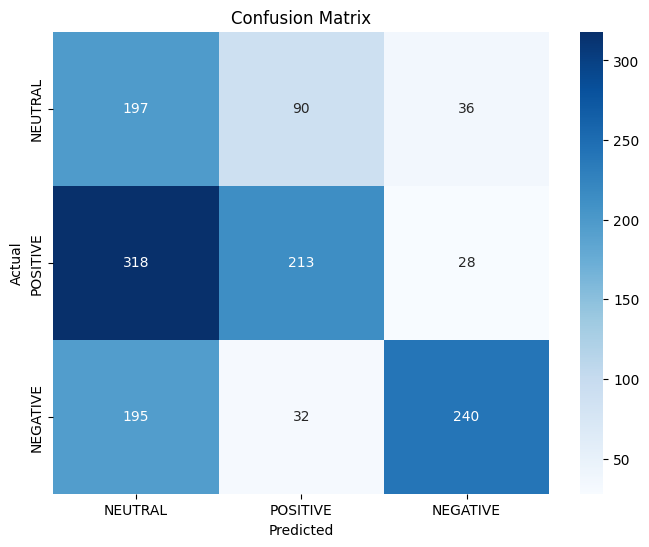

              precision    recall  f1-score   support

     NEUTRAL       0.79      0.51      0.62       467
    POSITIVE       0.28      0.61      0.38       323
    NEGATIVE       0.64      0.38      0.48       559

    accuracy                           0.48      1349
   macro avg       0.57      0.50      0.49      1349
weighted avg       0.60      0.48      0.50      1349



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(y_test, sent_val, labels=["NEUTRAL", "POSITIVE", "NEGATIVE"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["NEUTRAL", "POSITIVE", "NEGATIVE"], yticklabels=["NEUTRAL", "POSITIVE", "NEGATIVE"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Compute precision, recall, and F1-score
report = classification_report(y_test, sent_val, target_names=["NEUTRAL", "POSITIVE", "NEGATIVE"])
print(report)

In [31]:
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from tqdm import tqdm  # for progress bars

# Define a custom dataset
class HeadlineDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Mapping textual labels to numeric values
label_mapping = {"NEUTRAL": 1, "POSITIVE": 2, "NEGATIVE": 0}
y_train_numeric = [label_mapping[label] for label in y_train]

# Adjust the prepare_data function
def prepare_data(texts, numeric_labels):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    labels = torch.tensor(numeric_labels)  # Convert numeric labels to a tensor
    return inputs, labels

# Tokenize and create datasets with numeric labels
X_train_encodings, y_train_tensor = prepare_data(X_train, y_train_numeric)
train_dataset = HeadlineDataset(X_train_encodings, y_train_tensor)


# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Prepare the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Set the model to training mode
model.train()

# Training loop
for epoch in range(10):  # number of epochs
    loop = tqdm(train_loader, leave=True)  # create a progress bar
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

# Evaluate on test data (no changes here, just repeat the evaluation part)
labels = {1: 'NEUTRAL', 2: 'POSITIVE', 0: 'NEGATIVE'}
sent_val = []
for i in range(0, len(X_test), batch_size):
    batch_texts = X_test[i:i+batch_size]
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=400)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)[0]
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()  # Move to CPU here

    batch_labels = [labels[pred] for pred in predictions]
    sent_val.extend(batch_labels)

print(accuracy_score(y_test, sent_val))


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/78 [00:00<?, ?it/s]/tmp/ipykernel_34/1803848719.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/1803848719.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
Epoch 9: 100%|██████████| 78/78 [00:30<00:00,  2.58it/s, loss

0.5722757598220904
